# Plotting Notebook
This jupyter notebook contains the plotting functionality for PhageScanner. All of the sections in this notebook were used for plotting different results pertaining to the tool. Of note, the imports used in this analysis notebook depend on some of the PhageScanner libraries. Therefore the `environment.yml` should be ran and activated before using this notebook.

In [1]:
import pandas as pd
import sys
from enum import Enum
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sys.path.insert(0, '../') # need to reference directory containing modules
from PhageScanner.main.utils import CSVUtils

# File Paths
Change these file paths if wanting to benchmark different output files

In [397]:
class FilePaths(str, Enum):
    """Paths to all of the files used for benchmarking/analysis."""
    # feature testing
    feature_result_path = Path("../results/feature_model_results.csv")
    feature_classnames_path = Path("../results/feature_index2class_name.csv")
    
    # binary classification results
    binary_result_path = Path("../results/binary_model_results.csv")
    binary_classnames_path = Path("../results/binary_index2class_name.csv")
    
    # multiclass classification results
    multiclass_result_path = Path("../results/multiclass_model_results.csv")
    multiclass_classnames_path = Path("../results/feature_index2class_name.csv")
    
    # clustering results
    clustering_result_path = Path("../results/result_cluster_ouput.csv")
    
    # genomes analysis
    genome_analysis_path = Path("../results/genomes_predictions.csv")

# Helper methods

In [643]:
# remove gridmarks
sns.set(style="white", palette="pastel", rc={"figure.dpi":300, 'savefig.dpi':300})

# change fonts to helvetica
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [379]:

def expand_colors(colors, num_intermediate):
    def hex_to_rgb(color):
        return tuple(int(color[i:i+2], 16) for i in (1, 3, 5))

    def rgb_to_hex(color):
        return '#{:02x}{:02x}{:02x}'.format(*color)

    def interpolate(color1, color2, num_intermediate):
        return [tuple(int(color1[i] + j * (color2[i] - color1[i]) / (num_intermediate + 1)) for i in range(3)) for j in range(1, num_intermediate + 1)]

    rgb_colors = [hex_to_rgb(color) for color in colors]

    expanded_colors = []
    for i in range(len(rgb_colors) - 1):
        expanded_colors.append(rgb_to_hex(rgb_colors[i]))
        for intermediate_color in interpolate(rgb_colors[i], rgb_colors[i+1], num_intermediate):
            expanded_colors.append(rgb_to_hex(intermediate_color))

    # Add the last color
    expanded_colors.append(rgb_to_hex(rgb_colors[-1]))

    return expanded_colors


colors = ["#7CFC00", "#1fc600", "#089000", "#0a5d00", "#063b00"]
num_intermediate = 3
shades_of_green = expand_colors(colors, num_intermediate)

In [381]:
print(shades_of_green)

['#7cfc00', '#64ee00', '#4de100', '#36d300', '#1fc600', '#19b800', '#13ab00', '#0d9d00', '#089000', '#088300', '#097600', '#096900', '#0a5d00', '#095400', '#084c00', '#074300', '#063b00']


# Database

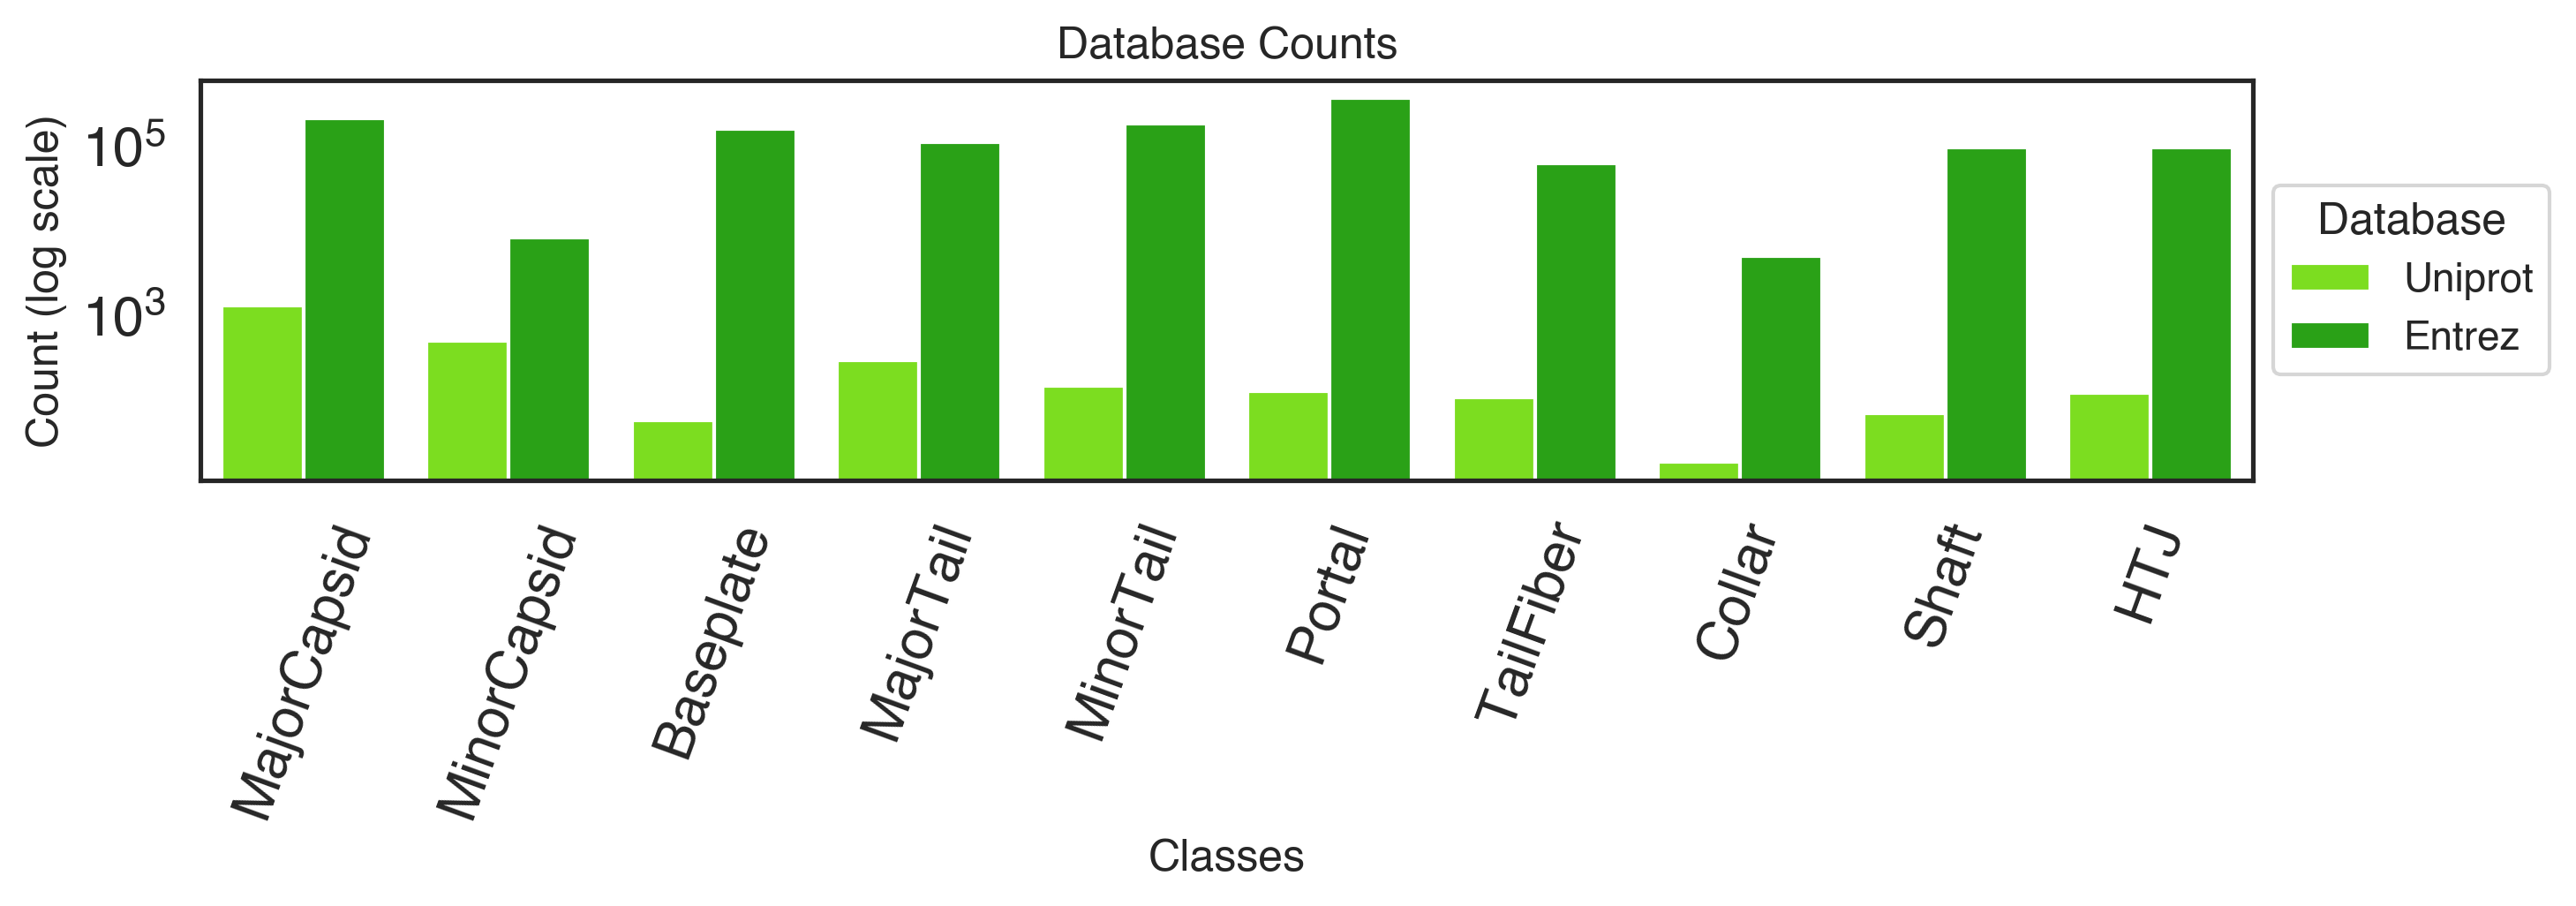

In [661]:
plt.figure(figsize=(10, 2))

# Define the data - same as printed information in log
data = {
    'PVP_class': ['MajorCapsid', 'MinorCapsid', 'Baseplate', 'MajorTail', 'MinorTail', 'Portal', 'TailFiber', 'Collar', 'Shaft', 'HTJ'],
    'Uniprot': [1334, 504, 59, 301, 149, 129, 109, 19, 72, 123],
    'Entrez': [209067, 8389, 157227, 110030, 184024, 363637, 62570, 5013, 96068, 96585]
}

df = pd.DataFrame(data)

df_long = df.melt('PVP_class', var_name='Database', value_name='Count')

ax = sns.barplot(x='PVP_class', y='Count', hue='Database', data=df_long, palette=[shades_of_green[0], shades_of_green[5]])
ax.set_yscale("log")

ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

plt.title('Database Counts')
plt.ylabel('Count (log scale)')
plt.xlabel('Classes')
ax.xaxis.set_tick_params(rotation=70)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Database")


plt.show()

# Plot feature comparisons

In [623]:
# data maniputation - open dataframes
feature_results_df = CSVUtils.csv_to_dataframe(FilePaths.feature_result_path)
index2class = CSVUtils.csv_to_dataframe(FilePaths.feature_classnames_path)

# select for newest datatime
feature_results_df['datetime'] = pd.to_datetime(feature_results_df['datetime'])
feature_results_df = feature_results_df[feature_results_df['datetime'] == feature_results_df['datetime'].max()]
del feature_results_df['datetime']

# turn tab seperates columns into arrays
feature_results_df['f1score'] = feature_results_df['f1score'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['precision'] = feature_results_df['precision'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['recall'] = feature_results_df['recall'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['features'] = feature_results_df['features'].str.replace('\t', "; ")

# create index to class map
del index2class["datetime"]
index2class = {int(k): v[0] for k, v in index2class.items()}

# add classes as a list
feature_results_df['classes'] = [list(index2class.values())]*len(feature_results_df)

# Flatten the lists
df_exploded = feature_results_df.apply(lambda x: x.explode()).reset_index(drop=True)

df_exploded = df_exploded.sort_values('accuracy', ascending=False)

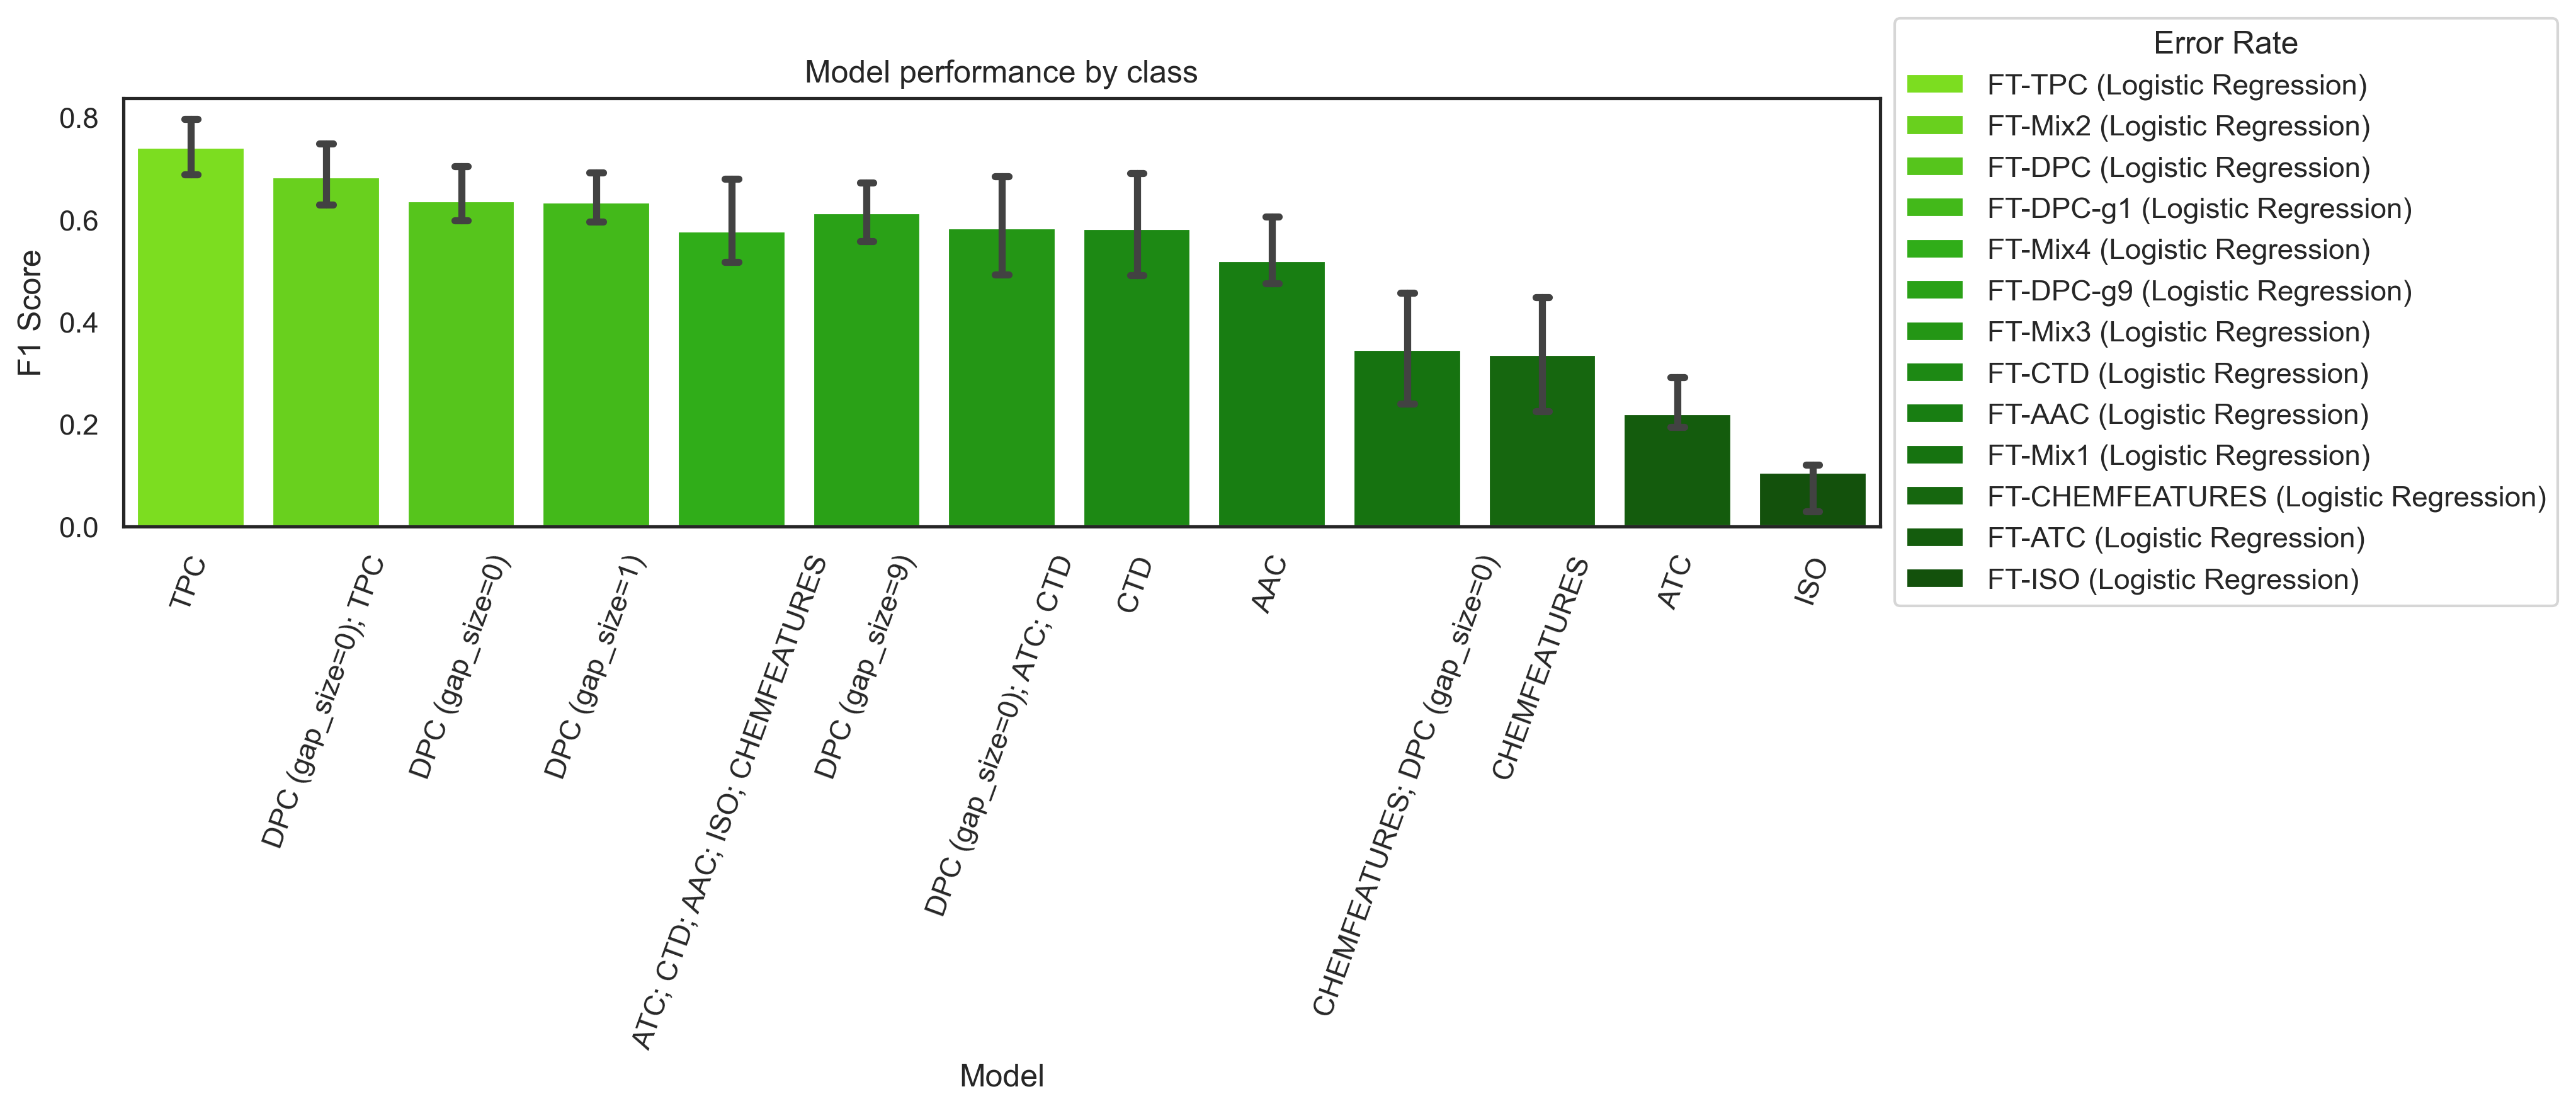

In [624]:
# Plotting
plt.figure(figsize=(12, 3))

# Create barplot
ax = sns.barplot(x='features', y='f1score', errorbar=("pi", 50), capsize=0.1, hue='model', dodge=False, data=df_exploded, palette=shades_of_green)

plt.title('Model performance by class')
plt.ylabel('F1 Score')
plt.xlabel('Model')
ax.xaxis.set_tick_params(rotation=70)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Error Rate")

# save and show figure
plt.savefig('features_comparison.png', dpi=300, bbox_inches='tight')

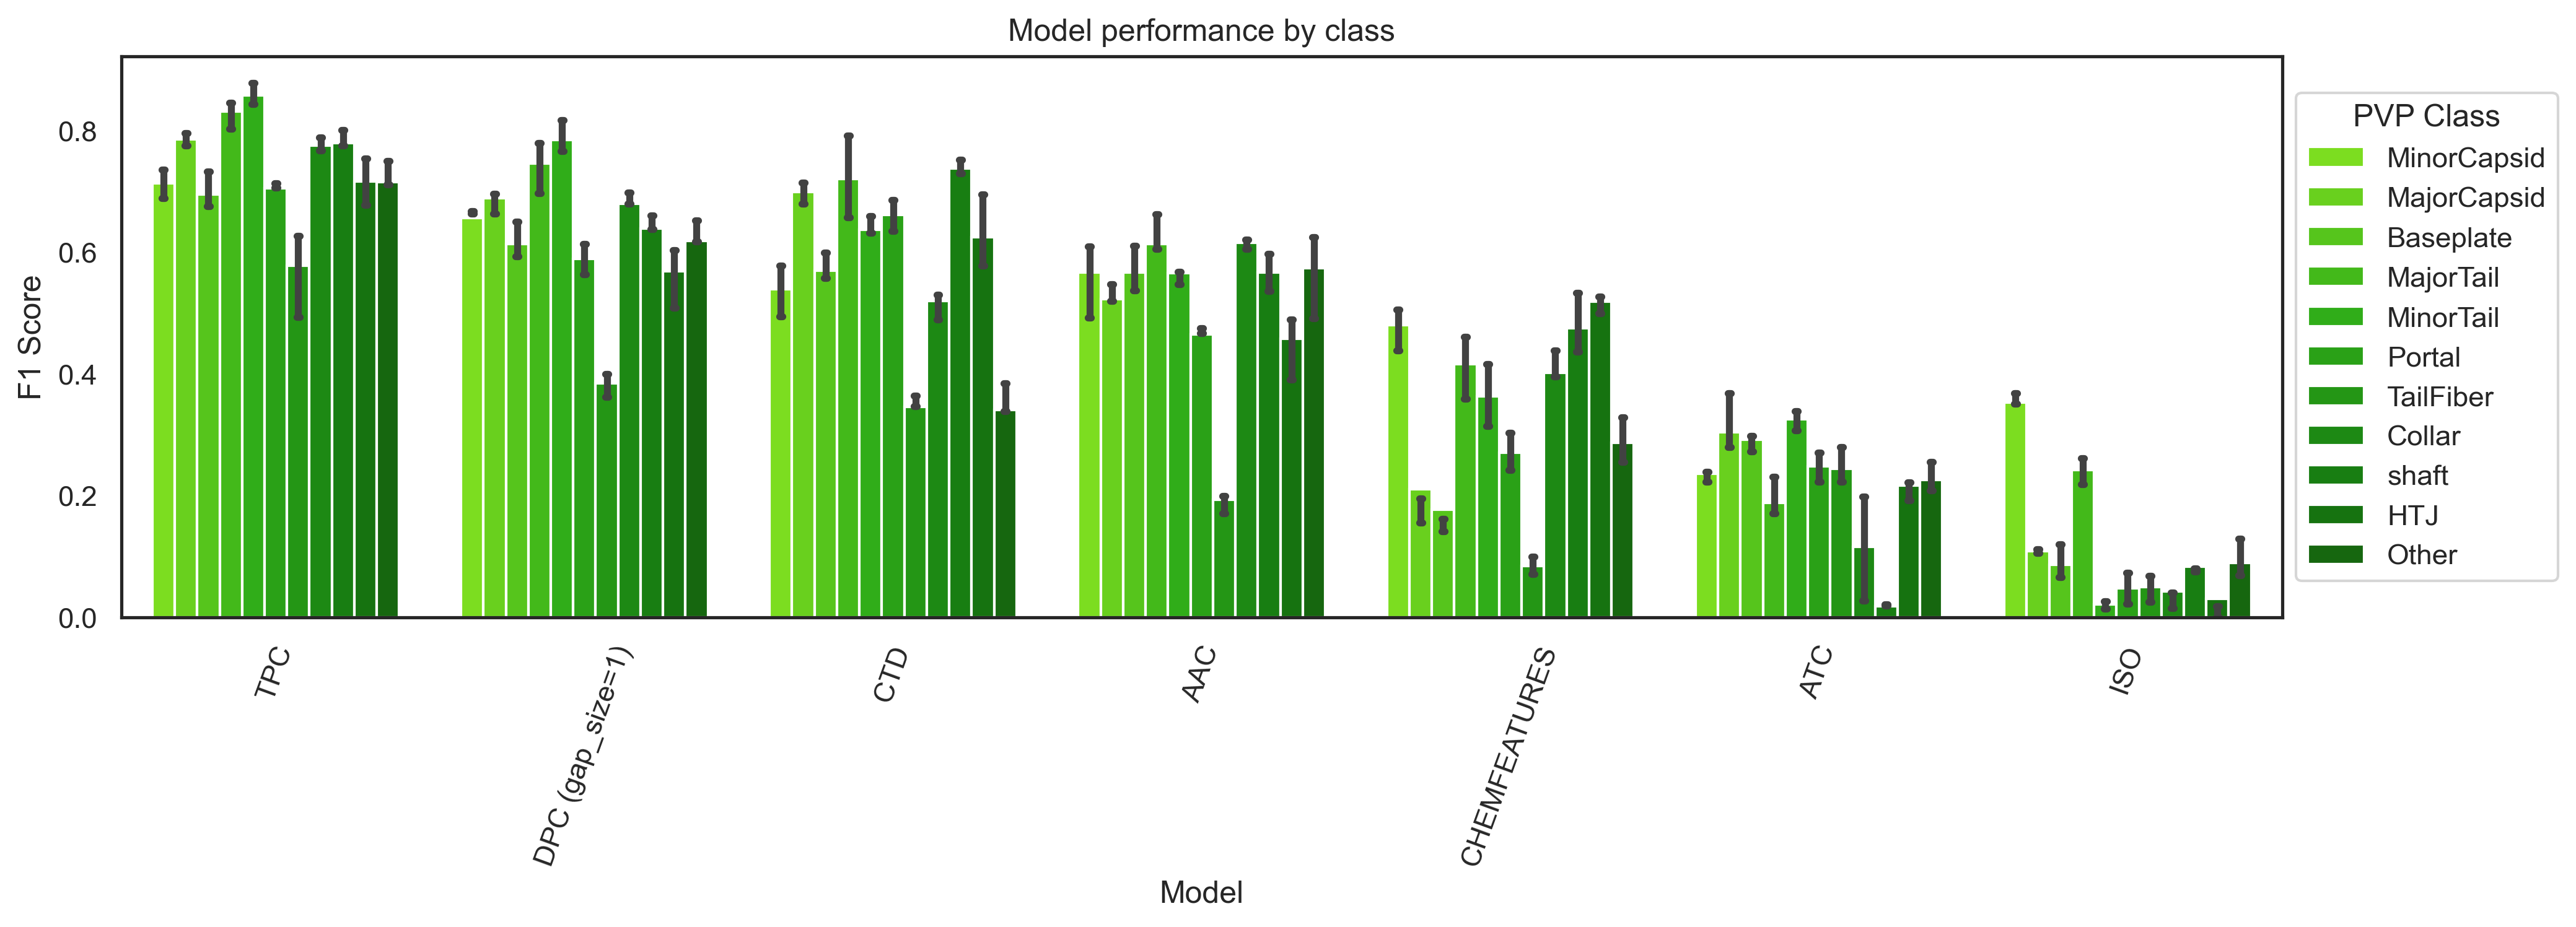

In [626]:
# Plotting
plt.figure(figsize=(15, 4))

# get subset of columns
values = ['DPC (gap_size=1)']
for column in df_exploded['features'].unique():
    if ";" not in column and "DPC" not in column:
        values.append(column)
df_exploded_subset = df_exploded[df_exploded['features'].isin(values)]

# Create barplot
ax = sns.barplot(x='features', y='f1score', hue='classes', errorbar=("pi", 50), capsize=.01, data=df_exploded_subset, palette=shades_of_green)

plt.title('Model performance by class')
plt.ylabel('F1 Score')
plt.xlabel('Model')
ax.xaxis.set_tick_params(rotation=70)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("PVP Class")

# save and show figure
plt.savefig('features_by_class.png', dpi=300, bbox_inches='tight')

In [459]:
# Assuming df is your DataFrame and 'column_to_group' is the column you want to group by
grouped_df = df_exploded.groupby(['features']).max()  # replace .mean() with any other aggregation function as needed

# Now you can save it to a CSV file
grouped_df #.to_csv('grouped_data.csv')
# del grouped_df['model']
del grouped_df['model']
del grouped_df['dataset_size']
del grouped_df['classes']
del grouped_df['kfold_iteration']
print(grouped_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  accuracy &  f1score &  precision &  recall &  execution\_time\_seconds \\
features                         &           &          &            &         &                         \\
\midrule
AAC                              &     0.562 &    0.725 &      0.865 &   0.732 &                0.000728 \\
ATC                              &     0.261 &    0.384 &      0.668 &   0.600 &                0.000875 \\
ATC; CTD; AAC; ISO; CHEMFEATURES &     0.637 &    0.790 &      0.892 &   0.721 &                0.002515 \\
CHEMFEATURES                     &     0.377 &    0.572 &      0.899 &   0.600 &                0.000973 \\
CHEMFEATURES; DPC (gap\_size=0)   &     0.386 &    0.574 &      0.902 &   0.640 &                0.004715 \\
CTD                              &     0.618 &    0.818 &      0.885 &   0.765 &                0.002101 \\
DPC (gap\_size=0)                 &     0.663 &    0.823 &      0.895 &   0.865 &                0.005625 \\
DPC (gap\_si

# Plot confusion matrix

In [713]:
path_to_confusion = Path("../results/PhageScanner (RNN)_confusion_matrix.csv")
classnames_path = Path("../results/multiclass_index2class_name.csv")

In [714]:
# open confusion matrix
CSVData = open(path_to_confusion)
confusion_matrix = np.loadtxt(CSVData, delimiter=",")

confusion_matrix /= sum(confusion_matrix) 
# create index to class map
index2class = CSVUtils.csv_to_dataframe(classnames_path)
del index2class["datetime"]
classnames = [v[0] for k, v in index2class.items()]

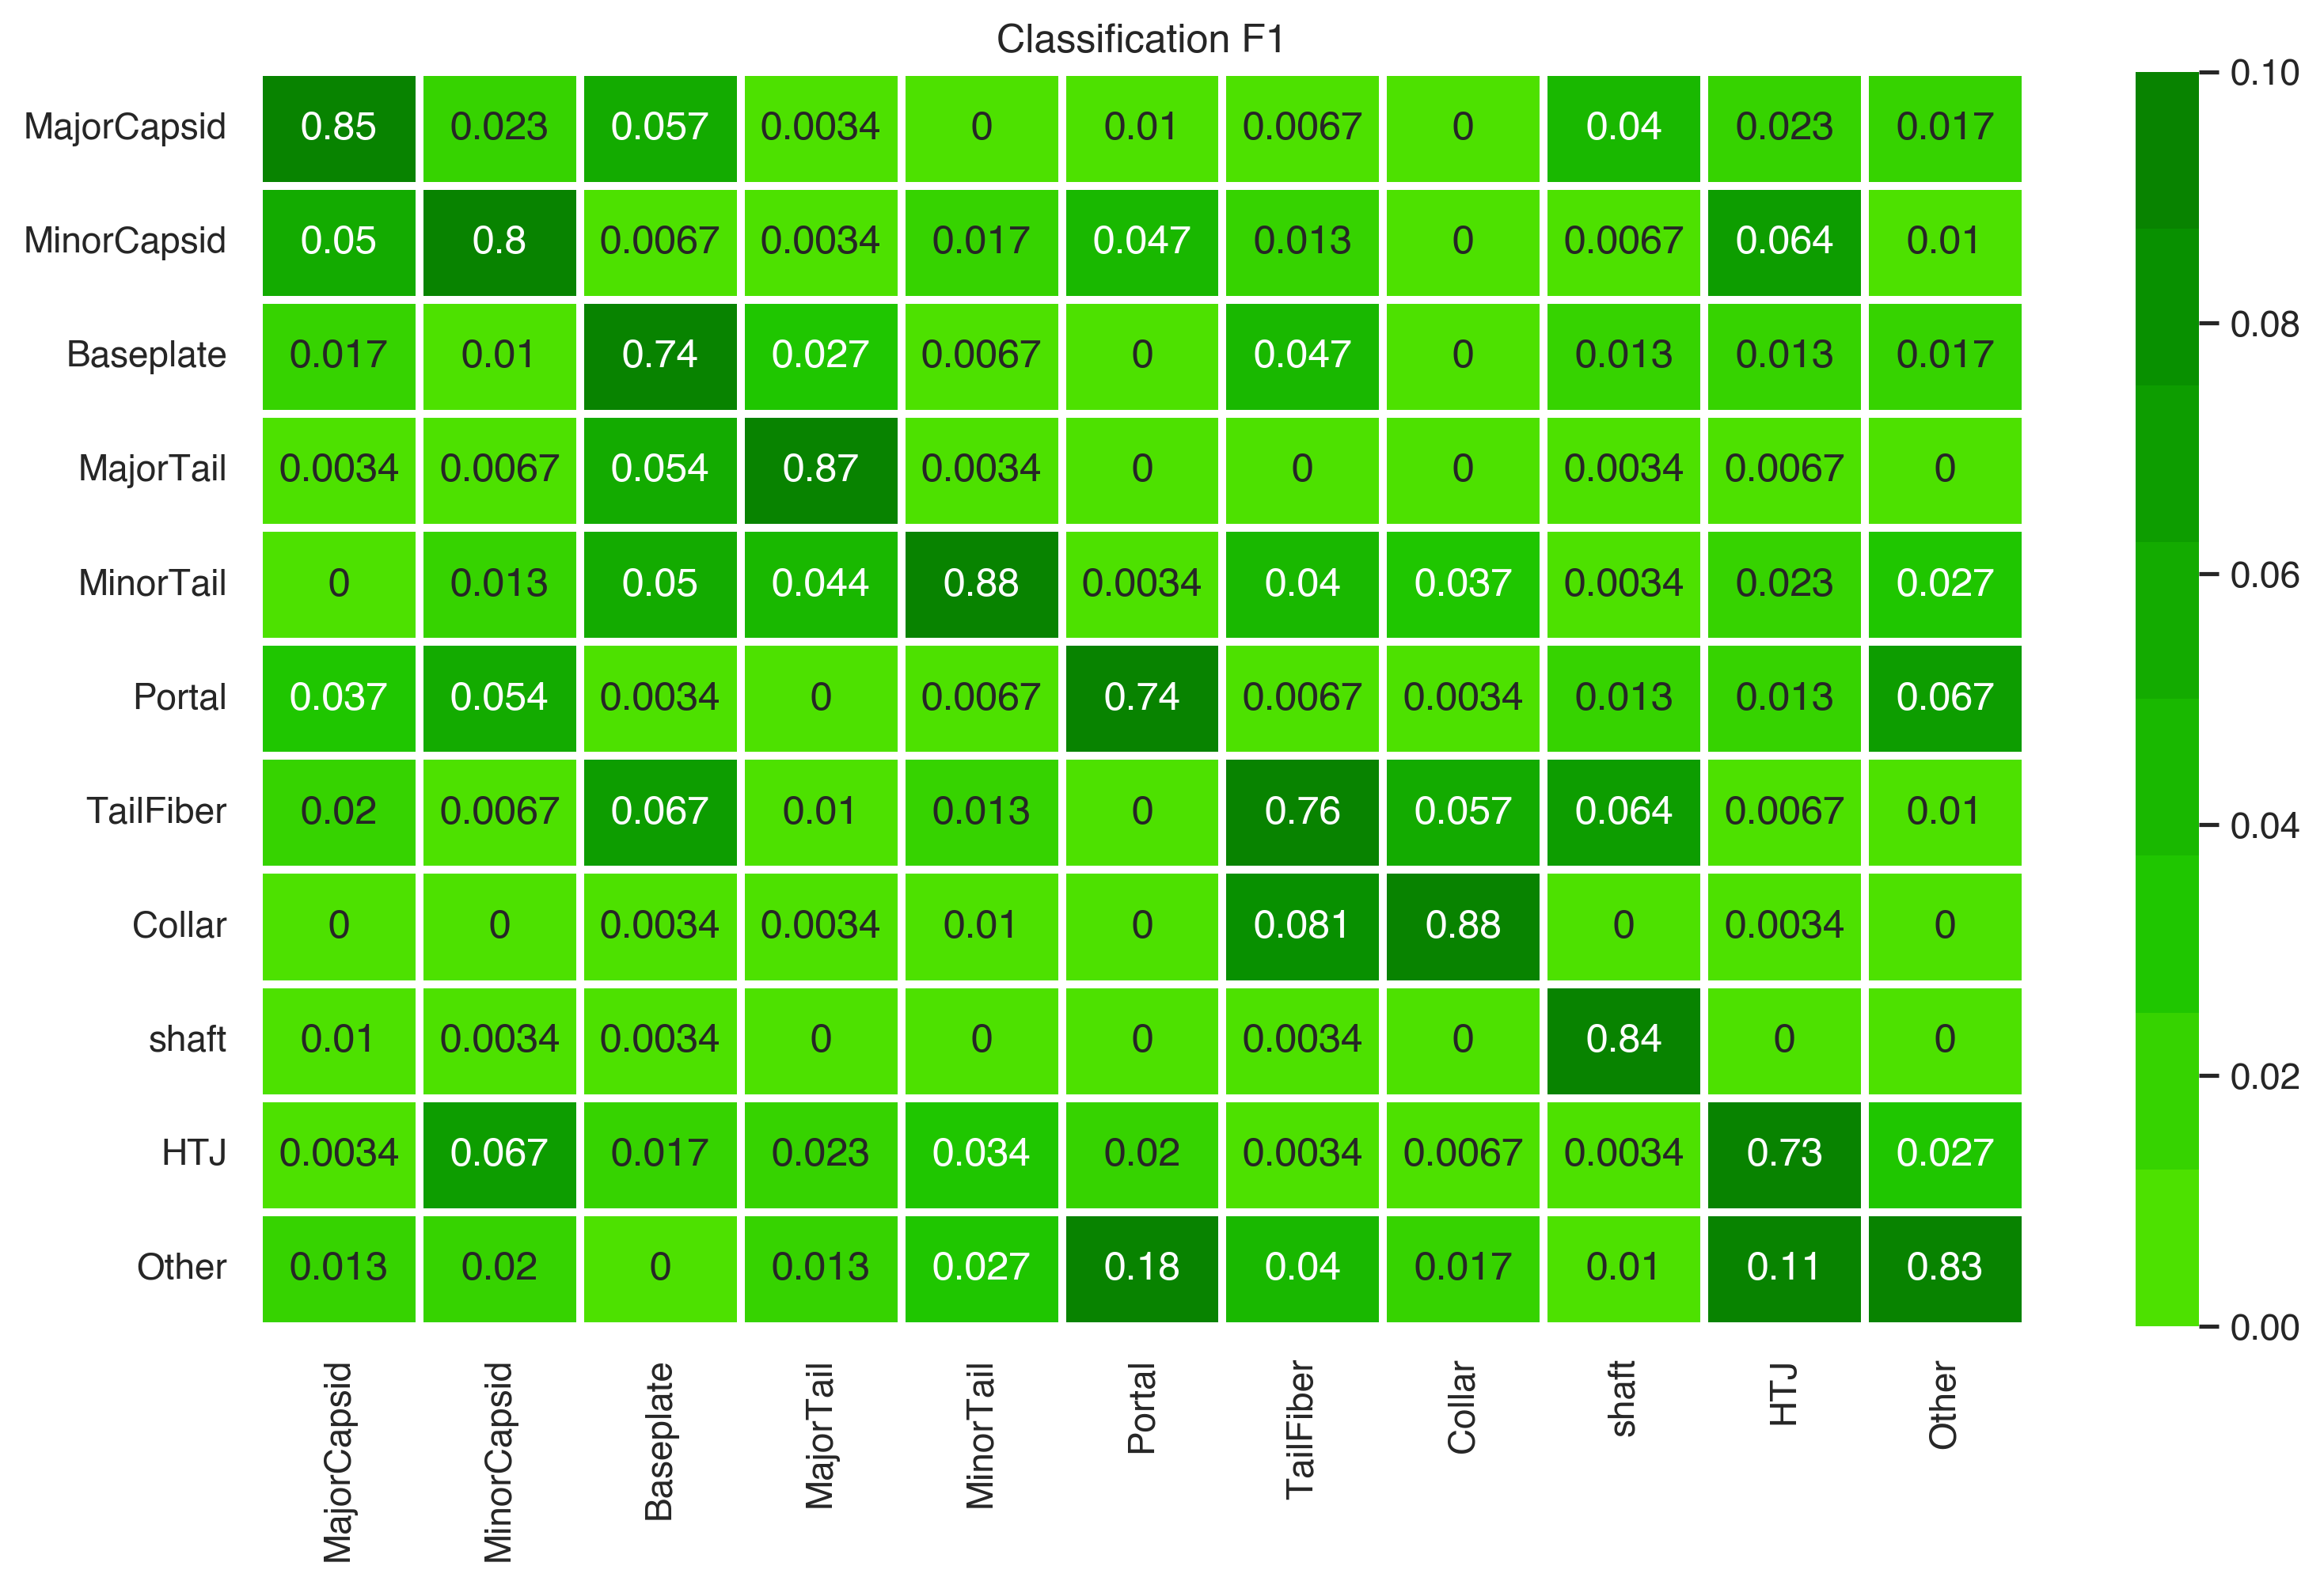

In [716]:
# plotting (classification)
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap(data=confusion_matrix, annot=True, linewidth=2, vmin=0, vmax=0.1, cmap=shades_of_green[2:10])
ax.set_title("Classification F1")

ax.set_xticks([tick + 0.5 for tick in range(len(classnames))])
ax.set_xticklabels(classnames)
ax.set_yticks([tick + 0.5 for tick in range(len(classnames))])
ax.set_yticklabels(classnames)
ax.xaxis.set_tick_params(rotation=90)
ax.yaxis.set_tick_params(rotation=0)

# save and show figure
plt.savefig('confusion_matrix_RNN.png', dpi=300, bbox_inches='tight')

# Multiclass/Binary - Plot accuracy and time

In [717]:
# data maniputation - open dataframes
data_type = 'Lysin'# set as `Binary` or `Multiclass` or `Lysin`
if data_type == 'Binary':
    feature_results_df = CSVUtils.csv_to_dataframe(FilePaths.binary_result_path)
    index2class = CSVUtils.csv_to_dataframe(FilePaths.binary_classnames_path)
elif data_type == 'Lysin':
    feature_results_df = CSVUtils.csv_to_dataframe("../results/lysin_model_results.csv")
    index2class = CSVUtils.csv_to_dataframe("../results/lysin_index2class_name.csv")
else:
    feature_results_df = CSVUtils.csv_to_dataframe(FilePaths.multiclass_result_path)
    index2class = CSVUtils.csv_to_dataframe(FilePaths.feature_classnames_path)

# select for newest datatime
feature_results_df['datetime'] = pd.to_datetime(feature_results_df['datetime'])
feature_results_df = feature_results_df[feature_results_df['datetime'] == feature_results_df['datetime'].max()]
del feature_results_df['datetime']

# drop the experimental hashseq
feature_results_df = feature_results_df[feature_results_df["model"].str.contains("HashSeq") == False]

### The below expands the classes into rows

In [718]:
# turn tab seperates columns into arrays
feature_results_df['f1score'] = feature_results_df['f1score'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['precision'] = feature_results_df['precision'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['recall'] = feature_results_df['recall'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['features'] = feature_results_df['features'].str.replace('\t', "; ")

# create index to class map
del index2class["datetime"]
index2class = {int(k): v[0] for k, v in index2class.items()}

# add classes as a list
feature_results_df['classes'] = [list(index2class.values())]*len(feature_results_df)

# Flatten the lists
df_exploded = feature_results_df.apply(lambda x: x.explode()).reset_index(drop=True)

# convert to numeric
df_exploded['f1score'] = pd.to_numeric(df_exploded['f1score'])
df_exploded['precision'] = pd.to_numeric(df_exploded['precision'])
df_exploded['recall'] = pd.to_numeric(df_exploded['recall'])

# order by performance
df_exploded = df_exploded.sort_values('f1score', ascending=False)

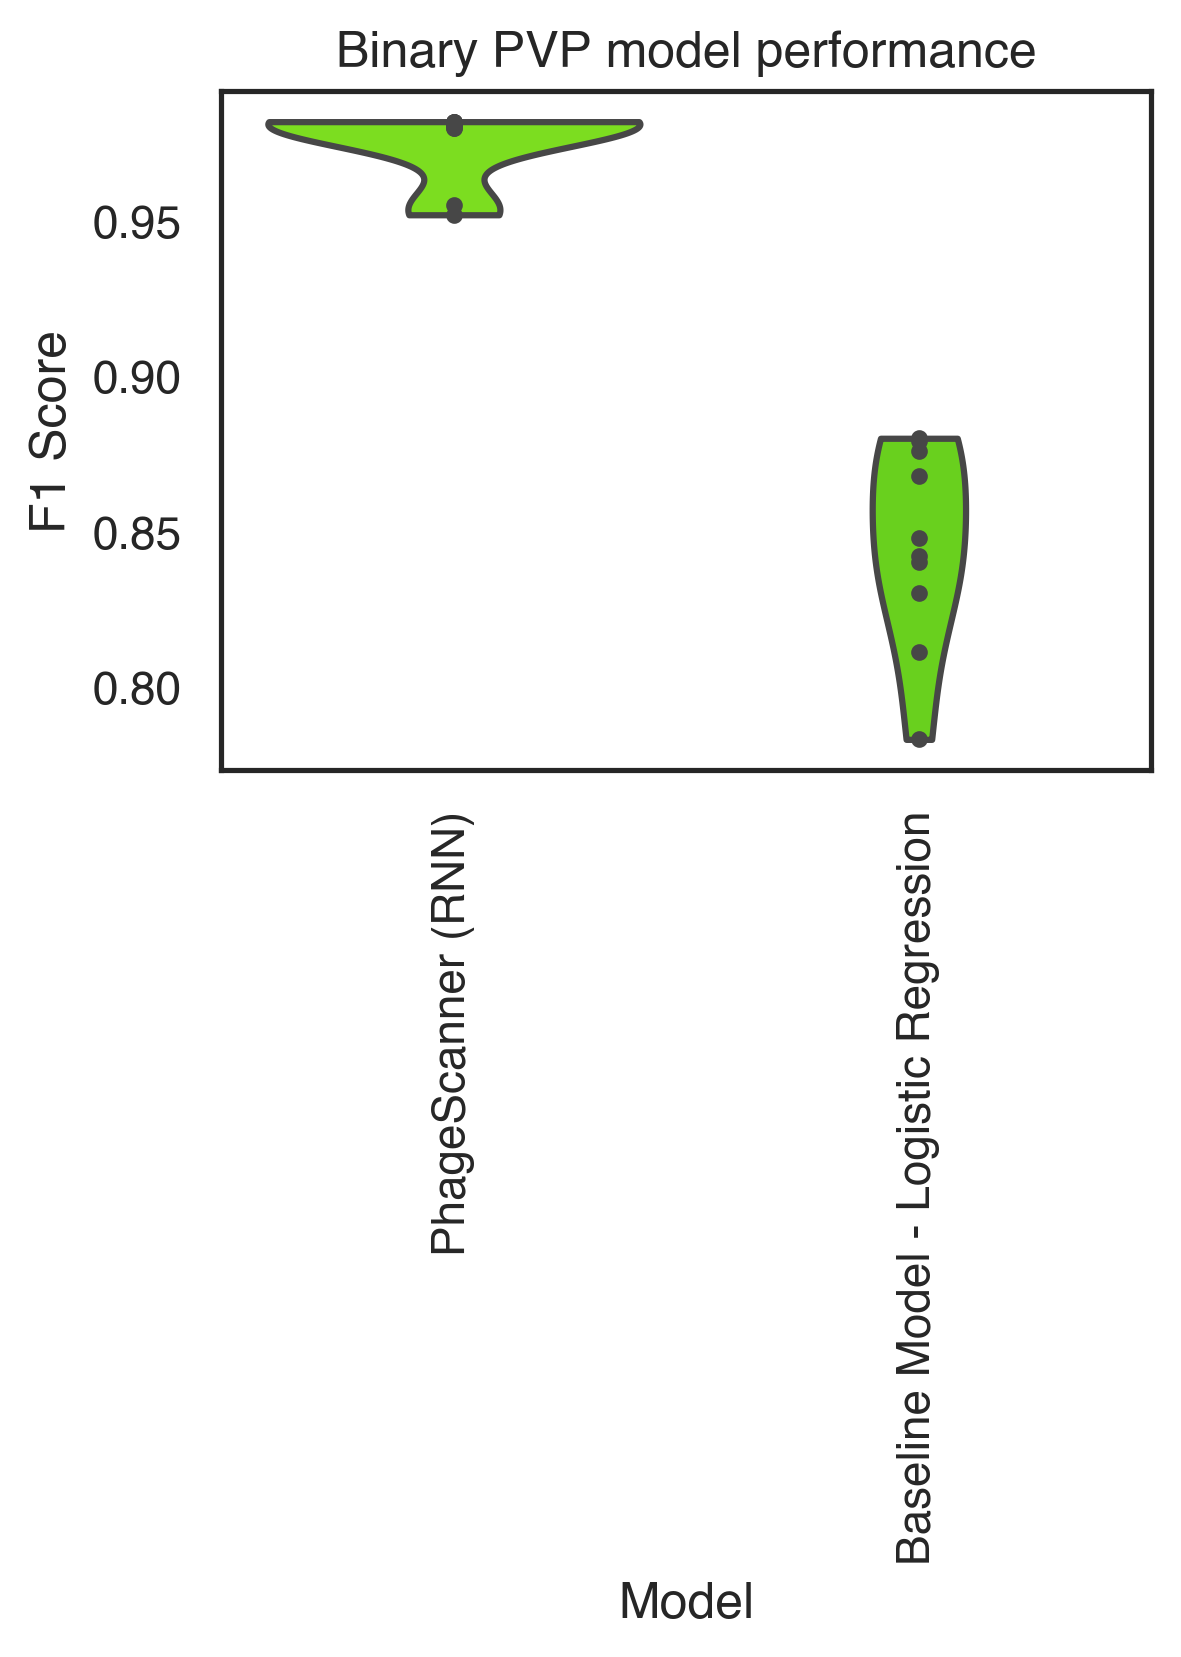

In [720]:
# Plotting
plt.figure(figsize=(4, 3))

# Create barplot
ax = sns.violinplot(data=df_exploded, x="model", y="f1score", cut=0, inner="point", palette=shades_of_green)

plt.title('Binary PVP model performance')
plt.ylabel('F1 Score')
plt.xlabel('Model')
ax.xaxis.set_tick_params(rotation=90)


plt.savefig(f'{data_type}_class_results.png', dpi=300, bbox_inches='tight')

In [708]:
mean_f1_per_model = df_exploded.groupby('model').mean()
mean_f1_per_model

,kfold_iteration,accuracy,f1score,precision,recall,execution_time_seconds,dataset_size
model,,,,,,,
BLAST,2.0,0.9404,0.940400,0.940473,0.941491,225.478115,3038.2
Baseline Model - Logistic Regression,2.0,0.6432,0.636109,0.643145,0.663236,0.003525,3038.2
DeePVP (CNN),2.0,0.7474,0.747927,0.747364,0.759200,0.896363,3038.2
PhANNs (FFNN),2.0,0.8640,0.864164,0.863945,0.867255,0.261310,3038.2
PhageScanner (RNN),2.0,0.8226,0.822618,0.822491,0.827255,1.989397,3038.2


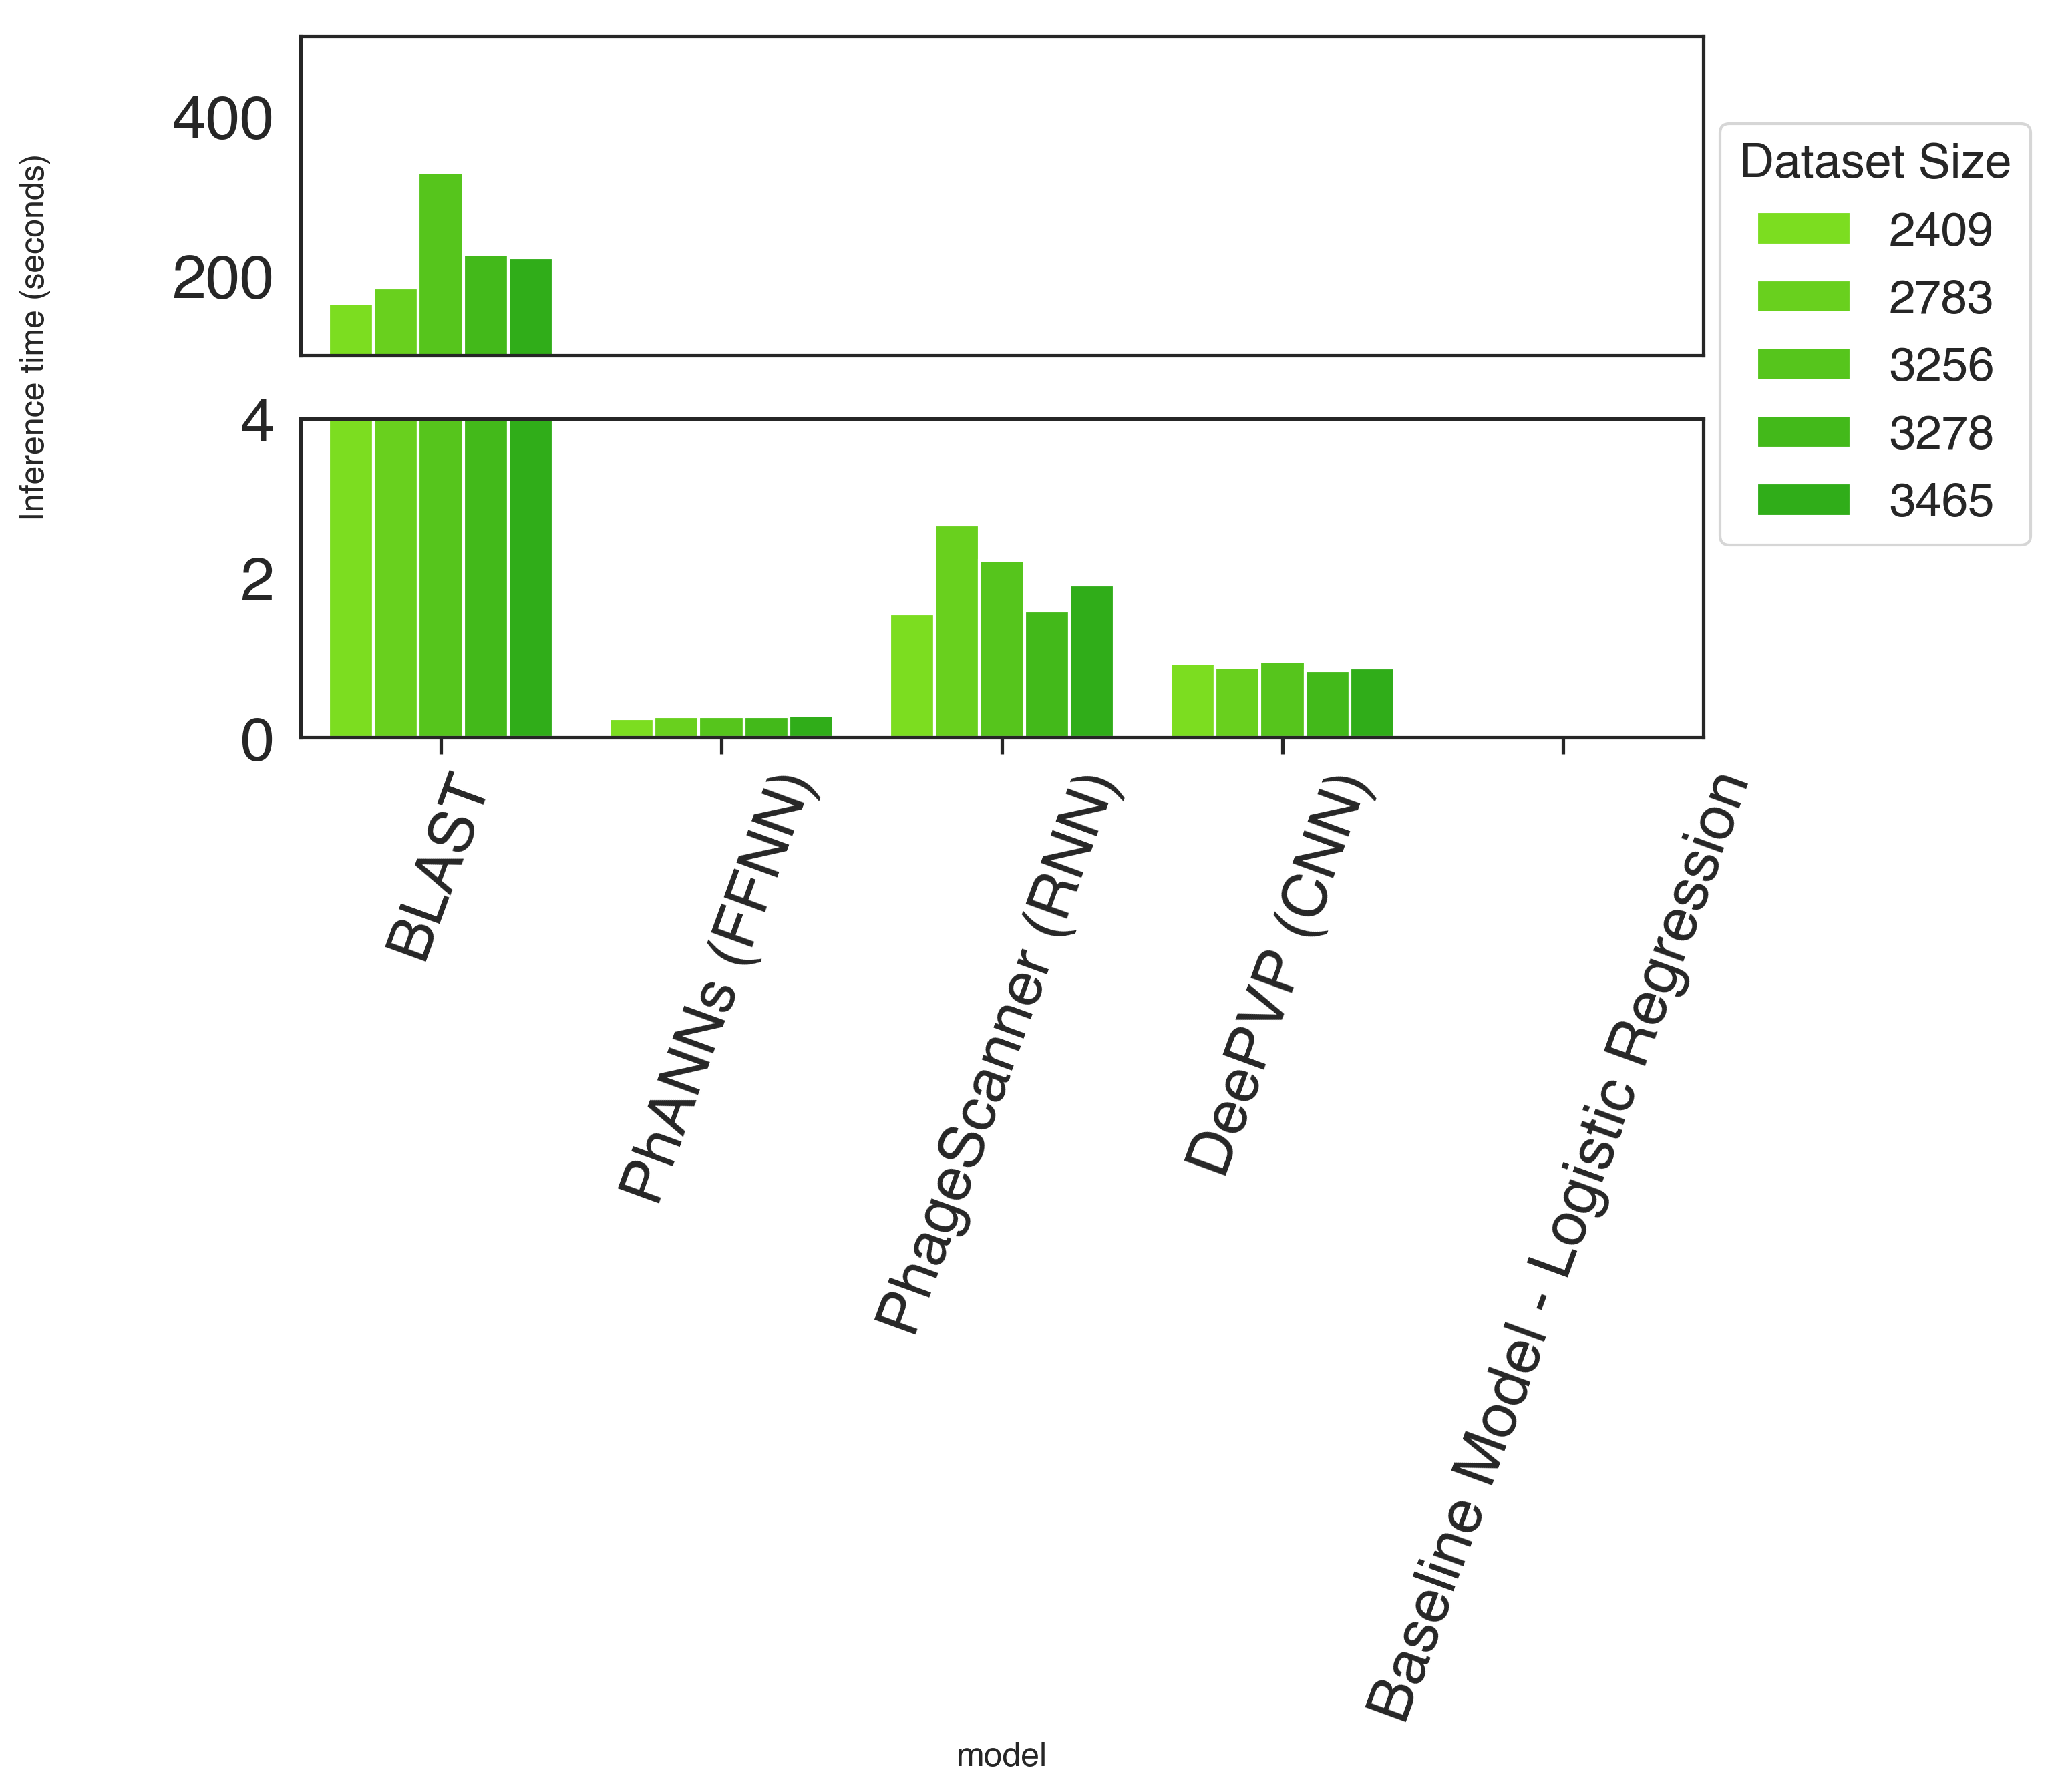

In [709]:

f, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=1, nrows=2, sharex=True)

# df_exploded = df_exploded.sort_values('execution_time_seconds', ascending=False)


# (you could turn this around if you need to, depending on what kind of data you want to show)
ax1 = sns.barplot(data=df_exploded, x="model", y="execution_time_seconds", hue='dataset_size', dodge=True, ax=ax1, palette=shades_of_green)

# we basically do the same thing again for the second plot
ax2 = sns.barplot(data=df_exploded, x="model", y="execution_time_seconds", hue='dataset_size', dodge=True, ax=ax2, palette=shades_of_green)

# CHANGE THESE DEPENDING ON OUTPUT
ax2.set_ylim(0, 4)
if data_type == 'Binary':
    ax1.set_ylim(15, 50)
else:
    ax1.set_ylim(100, 500)

# the upper part does not need its own x axis as it shares one with the lower part
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("")
ax2.set_ylabel("")

# remove the legend for the second plot
ax1.get_legend().remove()

# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.01, 0.55, "Inference time (seconds)", va="center", rotation="vertical")

# set title for legend
legend = ax2.legend(fontsize="17", bbox_to_anchor=(1.25, 2))
legend.set_title("Dataset Size")

# Change the legend title font size
plt.setp(legend.get_title(), fontsize='x-large')

# tick label size
ax1.tick_params(axis='y', labelsize=22)
ax2.tick_params(axis='y', labelsize=22)
ax2.tick_params(axis='x', labelsize=22)

# let's put some ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
ax2.xaxis.set_tick_params(rotation=70)

# finally, adjust everything a bit to make it prettier (this just moves everything, best to try and iterate)
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

plt.savefig(f'{data_type}_timing_results.png', dpi=300, bbox_inches='tight')

# Per class assessment of PhageScanner RNN

In [710]:
# data maniputation - open dataframes
feature_results_df = CSVUtils.csv_to_dataframe(FilePaths.multiclass_result_path)
index2class = CSVUtils.csv_to_dataframe(FilePaths.multiclass_classnames_path)

# select for newest datatime
feature_results_df['datetime'] = pd.to_datetime(feature_results_df['datetime'])
feature_results_df = feature_results_df[feature_results_df['datetime'] == feature_results_df['datetime'].max()]
del feature_results_df['datetime']

# select for PhageScanner model
feature_results_df = feature_results_df[feature_results_df['model'] == 'PhageScanner (RNN)']


# turn tab seperates columns into arrays
feature_results_df['f1score'] = feature_results_df['f1score'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['precision'] = feature_results_df['precision'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['recall'] = feature_results_df['recall'].str.split('\t').apply(lambda x: [float(i) for i in x])
feature_results_df['features'] = feature_results_df['features'].str.replace('\t', "; ")

# create index to class map
del index2class["datetime"]
index2class = {int(k): v[0] for k, v in index2class.items()}

# add classes as a list
feature_results_df['classes'] = [list(index2class.values())]*len(feature_results_df)

# # Flatten the lists
df_exploded = feature_results_df.apply(lambda x: x.explode()).reset_index(drop=True)

# convert to numeric
df_exploded['f1score'] = pd.to_numeric(df_exploded['f1score'])
df_exploded['precision'] = pd.to_numeric(df_exploded['precision'])
df_exploded['recall'] = pd.to_numeric(df_exploded['recall'])

# order by performance
df_exploded['avg_f1score'] = df_exploded.groupby('classes')['f1score'].transform('mean')
df_exploded = df_exploded.sort_values('avg_f1score', ascending=False)

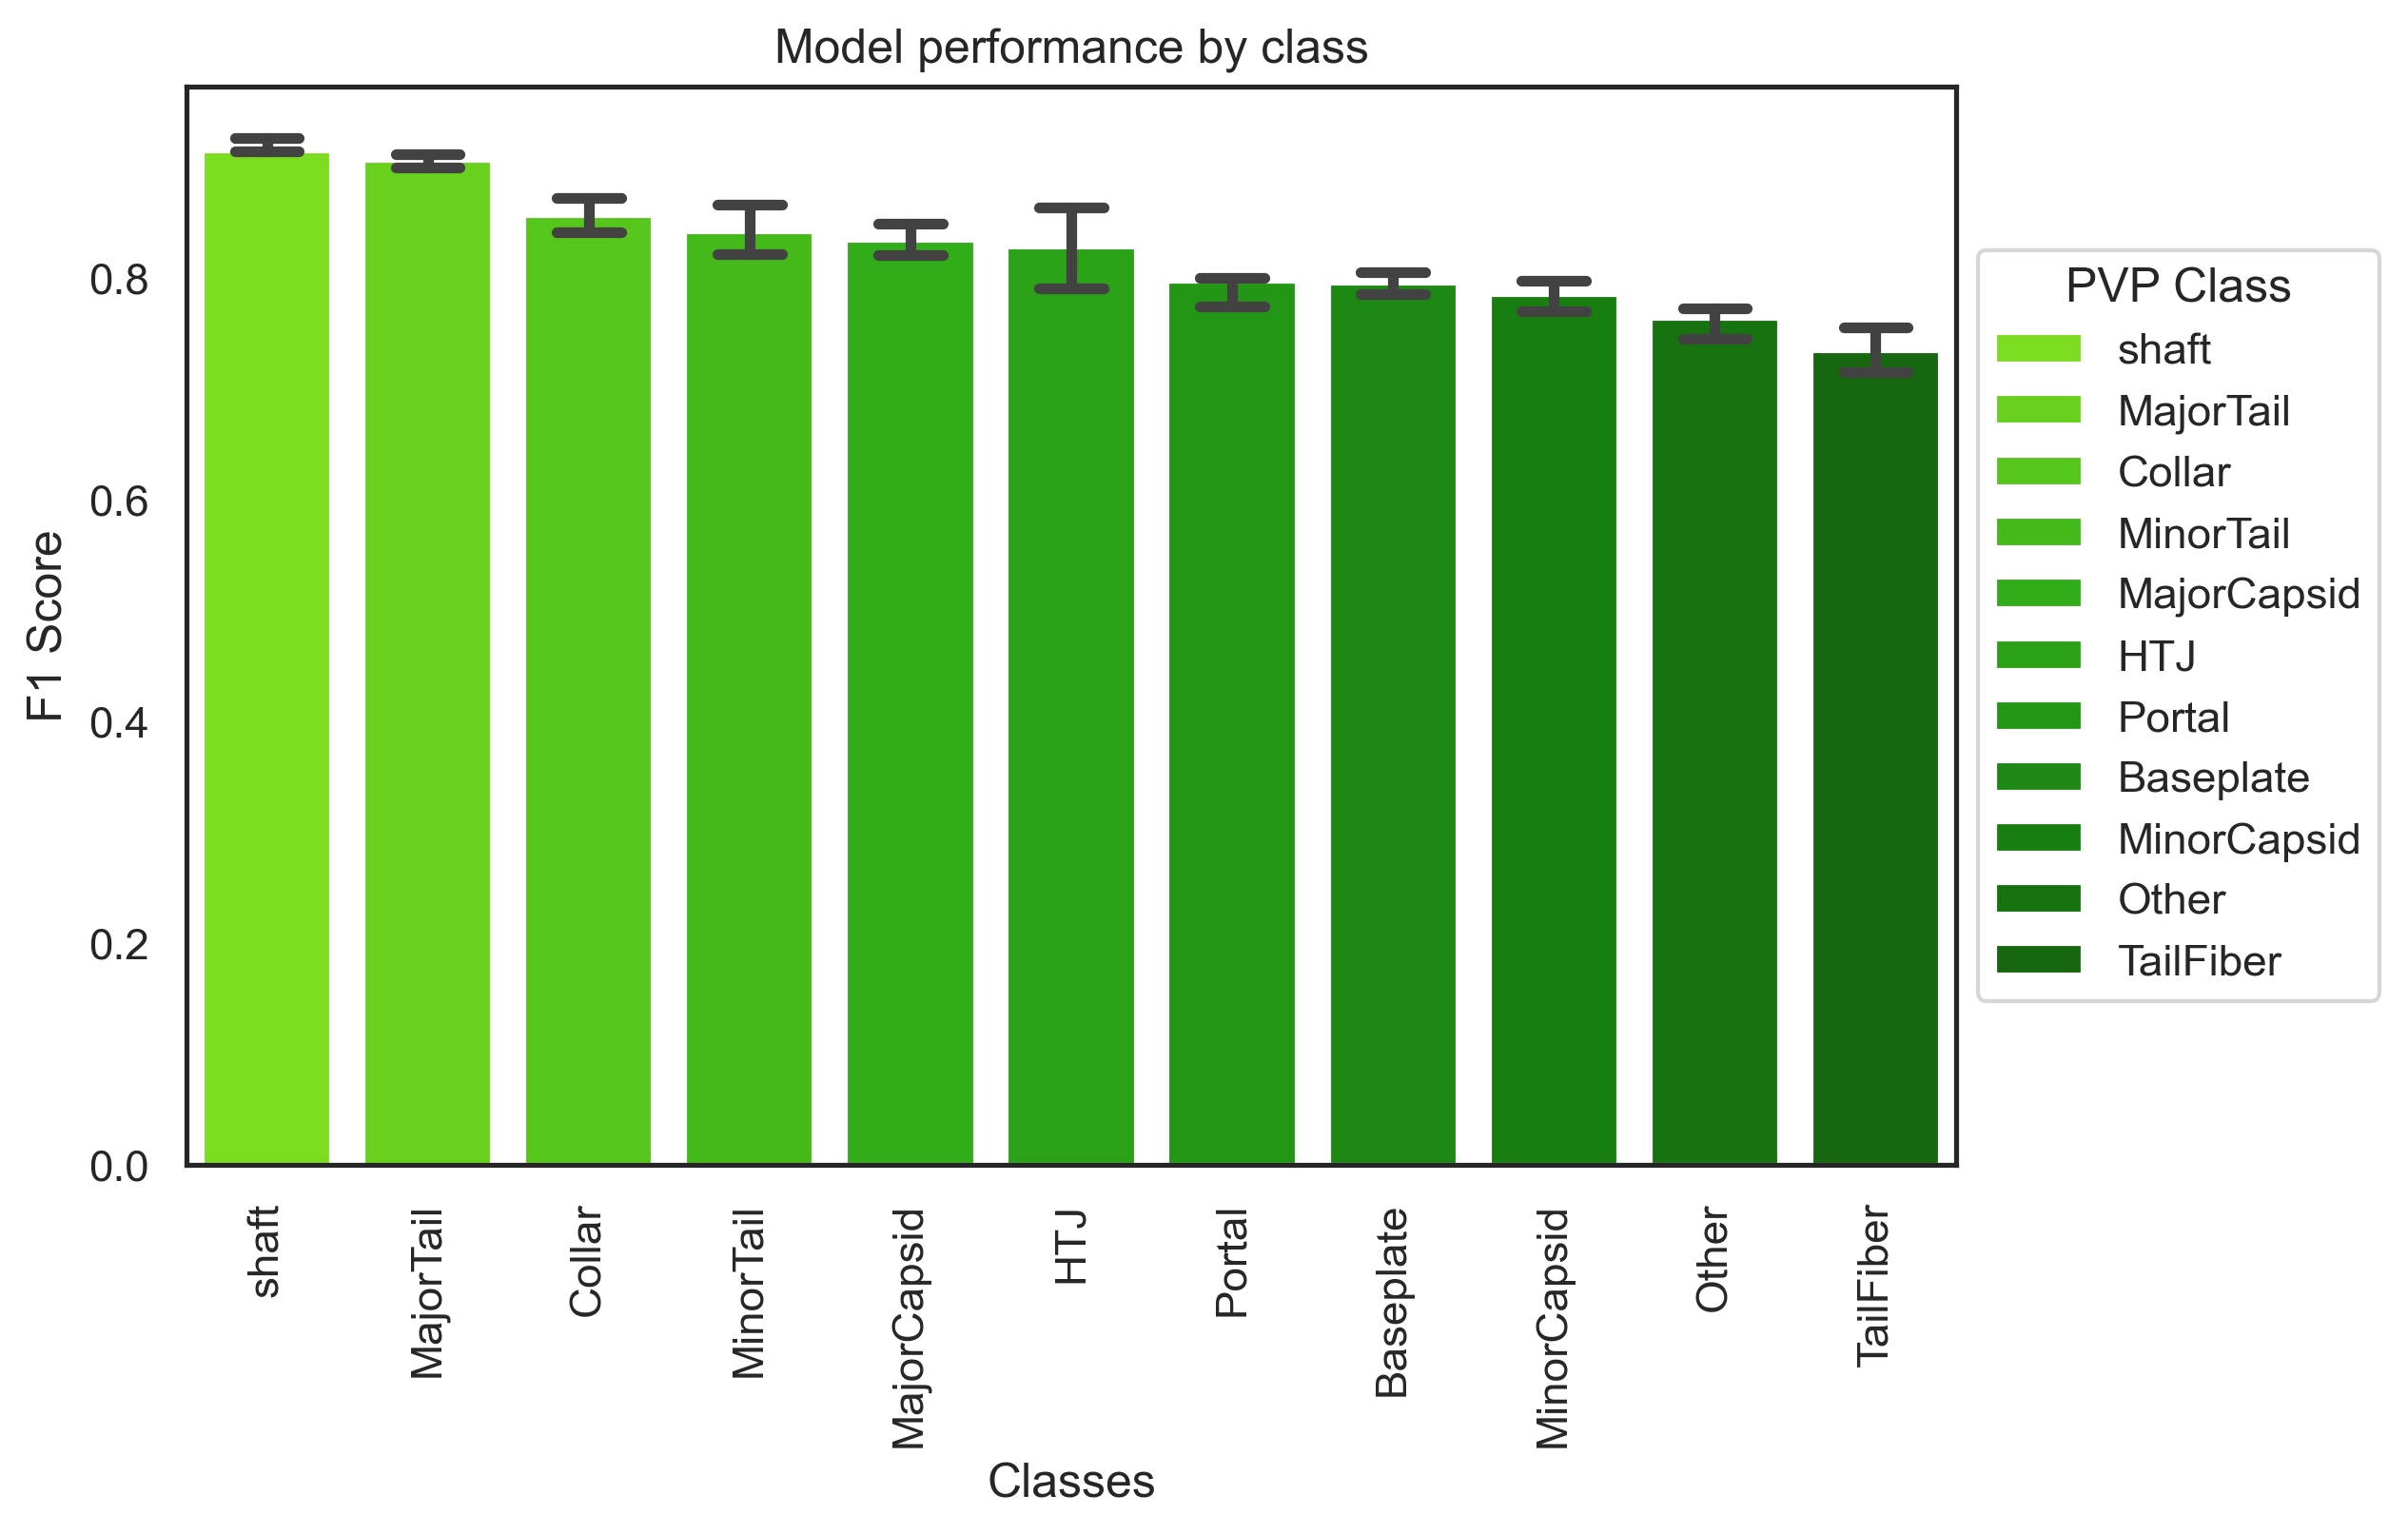

In [394]:
# Plotting
plt.figure(figsize=(8, 5))

# Create barplot
ax = sns.barplot(x='classes', y='f1score', hue='classes', errorbar=("pi", 50), capsize=.4, data=df_exploded, dodge=False, palette=shades_of_green)

plt.title('Model performance by class')
plt.ylabel('F1 Score')
plt.xlabel('Classes')
ax.xaxis.set_tick_params(rotation=90)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("PVP Class")

# save and show figure
plt.savefig('class_results_RNN.png', dpi=300, bbox_inches='tight')

In [631]:
# Plot accuracy and time for binary

# Plot cluster size for different thresholds

In [678]:
clustering_results_df = CSVUtils.csv_to_dataframe(FilePaths.clustering_result_path)

# order by inversely by threshold
clustering_results_df = clustering_results_df.sort_values("clustering_threshold", ascending=True)

/var/folders/4f/nzw4pyy13p90pvc1lkbpbjpc0000gn/T/ipykernel_30920/1115890260.py:5: UserWarning: The palette list has more values (17) than needed (10), which may not be intended.
  sns.lineplot(


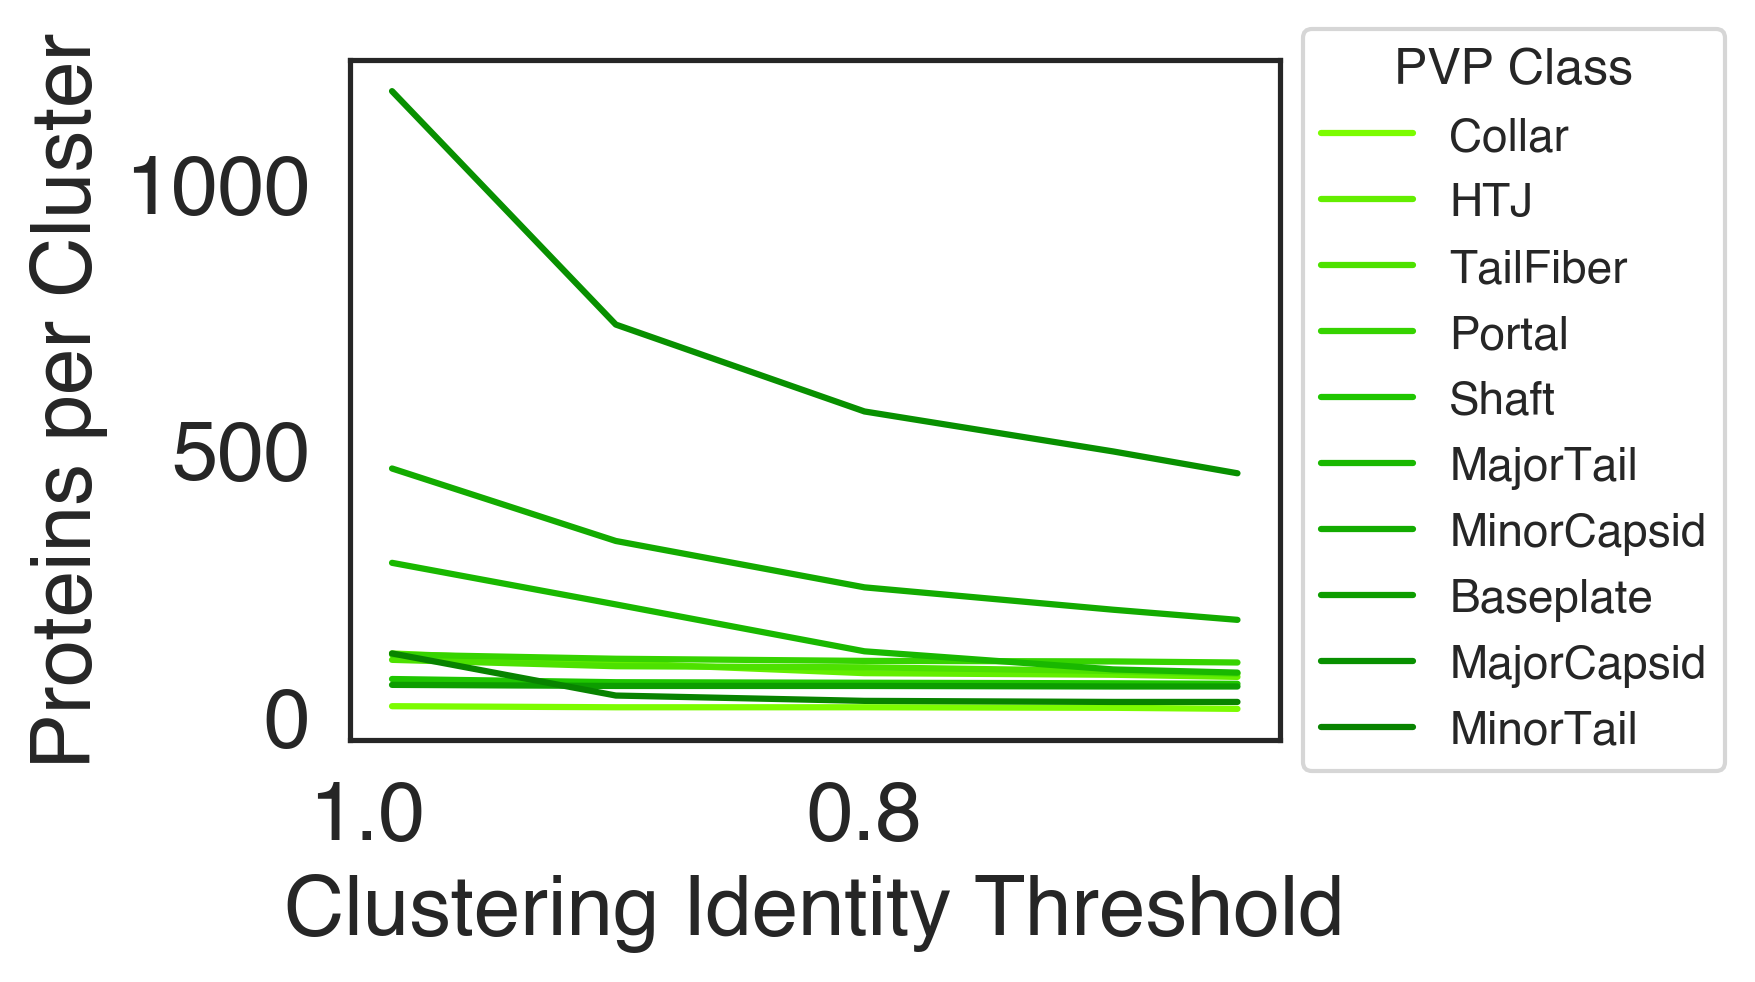

In [683]:
fig, ax1 = plt.subplots(figsize=(4, 3))
ax1.grid(False)

# plot
sns.lineplot(
    data=clustering_results_df,
    x="clustering_threshold", y="cluster_count", hue="class_name",
    markers=True, dashes=False,
    palette= shades_of_green
)

ax1.set_xlabel('Clustering Identity Threshold', size=20)
ax1.set_ylabel('Proteins per Cluster', size=20)

ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("PVP Class")

# Invert x-axis
ax1 = plt.gca()
ax1.invert_xaxis()

plt.show()

# Cluster sizes

In [665]:
cluster_sizes_path = Path("../results/cluster_sizes.csv")
cluster_sizes_df = CSVUtils.csv_to_dataframe(cluster_sizes_path)

# get cluster sizes per row
cluster_sizes_df['cluster_sizes'] = cluster_sizes_df['cluster_sizes'].str.split('\t').apply(lambda x: [float(i) for i in x])
df_exploded = cluster_sizes_df.apply(lambda x: x.explode()).reset_index(drop=True)
df_exploded['cluster_sizes'] = pd.to_numeric(df_exploded['cluster_sizes'])

# select for specific class
# df_exploded = df_exploded[df_exploded['class_name'] == 'MinorCapsid']
df_exploded = df_exploded[df_exploded["cluster_sizes"] > 50]
df_exploded = df_exploded[df_exploded["cluster_sizes"] < 1000] #.sample(1000)
df_exploded

,datetime,class_name,cluster_count,cluster_sizes
146,Sat Jul 1 20:25:17 2023,MajorCapsid,49930,360.0
422,Sat Jul 1 20:25:17 2023,MajorCapsid,49930,87.0
962,Sat Jul 1 20:25:17 2023,MajorCapsid,49930,170.0
988,Sat Jul 1 20:25:17 2023,MajorCapsid,49930,121.0
997,Sat Jul 1 20:25:17 2023,MajorCapsid,49930,168.0
...,...,...,...,...
290547,Sat Jul 1 20:25:17 2023,non-PVP,11178,188.0
290833,Sat Jul 1 20:25:17 2023,non-PVP,11178,201.0
290834,Sat Jul 1 20:25:17 2023,non-PVP,11178,79.0
290861,Sat Jul 1 20:25:17 2023,non-PVP,11178,96.0


/var/folders/4f/nzw4pyy13p90pvc1lkbpbjpc0000gn/T/ipykernel_30920/2784296058.py:4: UserWarning: The palette list has more values (17) than needed (11), which may not be intended.
  sns.histplot(data=df_exploded, x="cluster_sizes", hue='class_name', bins=50, palette=shades_of_green, ax=ax1)


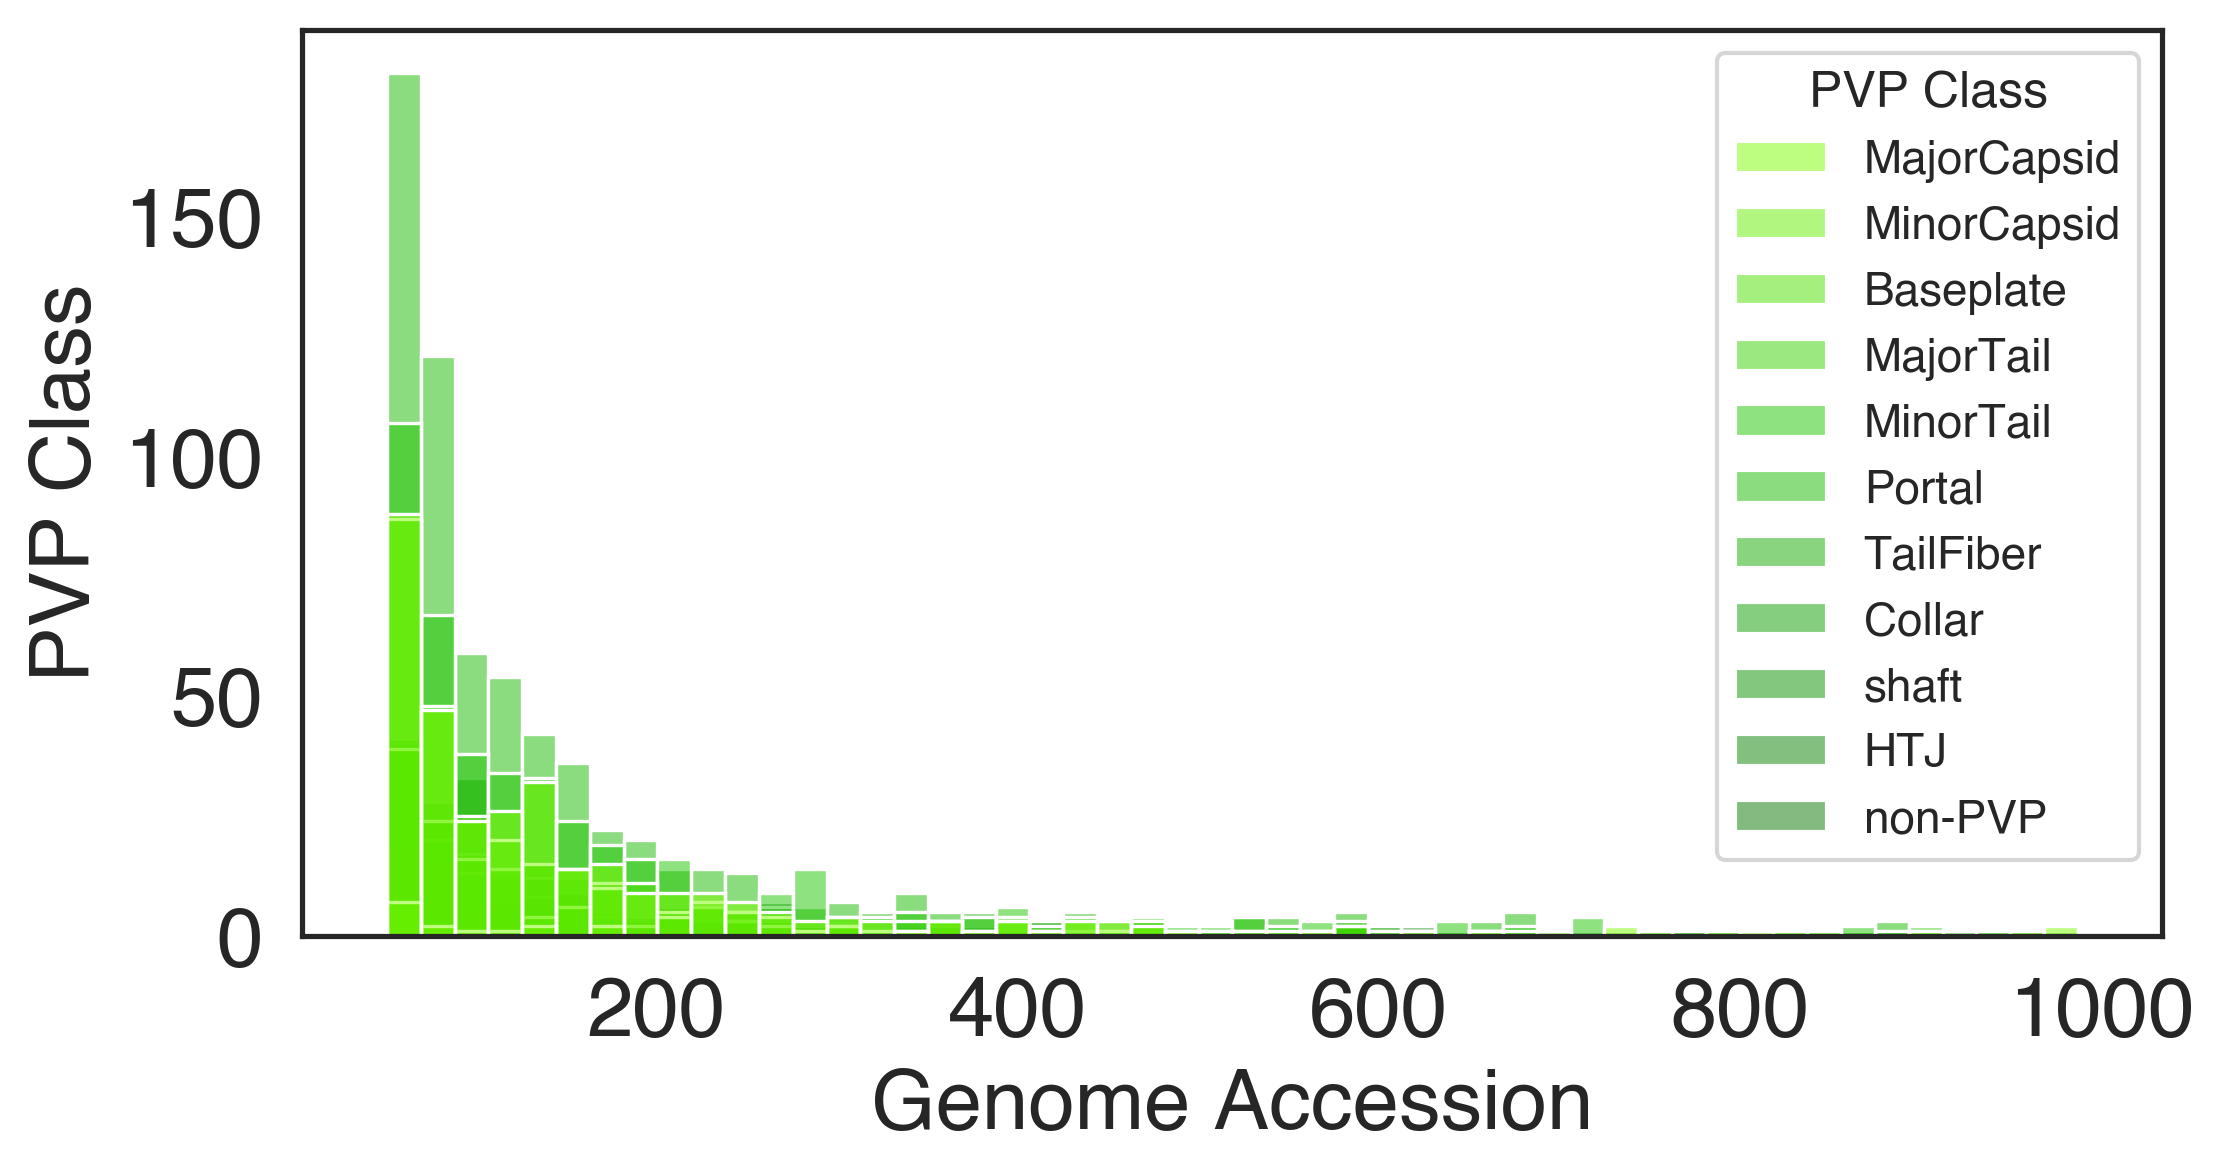

In [674]:
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.grid(False)

sns.histplot(data=df_exploded, x="cluster_sizes", hue='class_name', bins=50, palette=shades_of_green, ax=ax1)

ax1.set_xlabel('Clustering Identity Threshold')
ax1.set_ylabel('Proteins per Cluster')

legend = ax1.get_legend()
legend.set_title("PVP Class")

ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
plt.xlabel("Genome Accession", size=20)
plt.ylabel("PVP Class", size=20)

plt.show()

# Genome analysis

In [491]:
genome_df =  CSVUtils.csv_to_dataframe(FilePaths.genome_analysis_path)
genome_df

,accession,length,start_pos,stop_pos,orf_score,protein,PVP-SVM (SVM),PhageScanner (RNN),BLAST
0,MF417929,32618,2,215,-1.215588e+00,CCLVHHRCNGYTSIFITINSLLIIKNILCFYHFHLLAFNRILSHII...,non-PVP,TailFiber,Baseplate
1,MF417929,32618,198,1350,-1.882489e+09,MGTITKRITSTGEVRYRAQVRIKRKGLPDFTESKTFSKKSLASEWV...,non-PVP,HTJ,shaft
2,MF417929,32618,1699,1990,-2.128503e+02,MKNALDQFDSSFLLAMKYKLPVVTLETVVADFMPYLKIETAKKRAS...,non-PVP,TailFiber,TailFiber
3,MF417929,32618,1914,2133,-9.920198e+01,MFNVTPDHFLAKEAYEKAKSLKTSYVHILGSSYGIKGKEQYYLSGV...,non-PVP,shaft,Collar
4,MF417929,32618,2192,2468,-6.157546e+02,MNKAPLNLNSIPDLNLRQIEVLIEELENTYATGHADHPMLKVVNVS...,non-PVP,TailFiber,shaft
...,...,...,...,...,...,...,...,...,...
508,AC171169,104373,11780,12209,-3.486833e+03,MSDRFYTQMAEHFRIPHYELNIALRDHDSPEYKKLEKKAGKSIDTK...,non-PVP,shaft,Baseplate
509,AC171169,104373,12272,12689,-1.938087e+02,MFAELFTMMLLGIWKISLVVFVLMIVFTIIALTTRNSLLIKVIHGL...,non-PVP,HTJ,TailFiber
510,AC171169,104373,12763,13177,-3.109780e+04,MSFKFGKNSEKQLATVKPELQKVARRALELSPYDFTIVQGIRTVAQ...,non-PVP,MinorTail,Collar
511,AC171169,104373,13443,14127,-5.926957e+04,MVLVRGGYKLEKFLQLLTVLLQEAKDPASLLKRLLTILVAVIIFLF...,PVP,MinorCapsid,Portal


In [615]:
column_name = 'PhageScanner (RNN)' #'PhageScanner (RNN)'
# classes per genome
classes_per_genome = genome_df.groupby(['accession', column_name]).size().reset_index(name='Count')
classes_per_genome = classes_per_genome.pivot_table(index='accession', columns=column_name, values='Count', fill_value=0)

print(classes_per_genome.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
PhageScanner (RNN) &  Baseplate &  Collar &  HTJ &  MajorCapsid &  MajorTail &  MinorCapsid &  MinorTail &  Portal &  TailFiber &  shaft \\
accession &            &         &      &              &            &              &            &         &            &        \\
\midrule
AC171169  &          3 &       0 &    6 &            0 &          2 &           10 &          3 &       2 &          7 &      2 \\
BK010471  &         16 &       0 &   35 &            1 &          7 &           19 &          9 &       4 &          8 &      7 \\
GU339467  &          9 &      20 &   10 &            0 &         15 &           12 &         12 &      16 &          8 &      5 \\
MF417929  &          5 &       4 &   10 &            1 &          1 &            6 &          6 &       4 &         13 &      3 \\
MH552500  &          8 &       4 &   37 &            0 &         10 &           15 &         11 &       5 &         16 &      1 \\
MH616963  &         13 &   

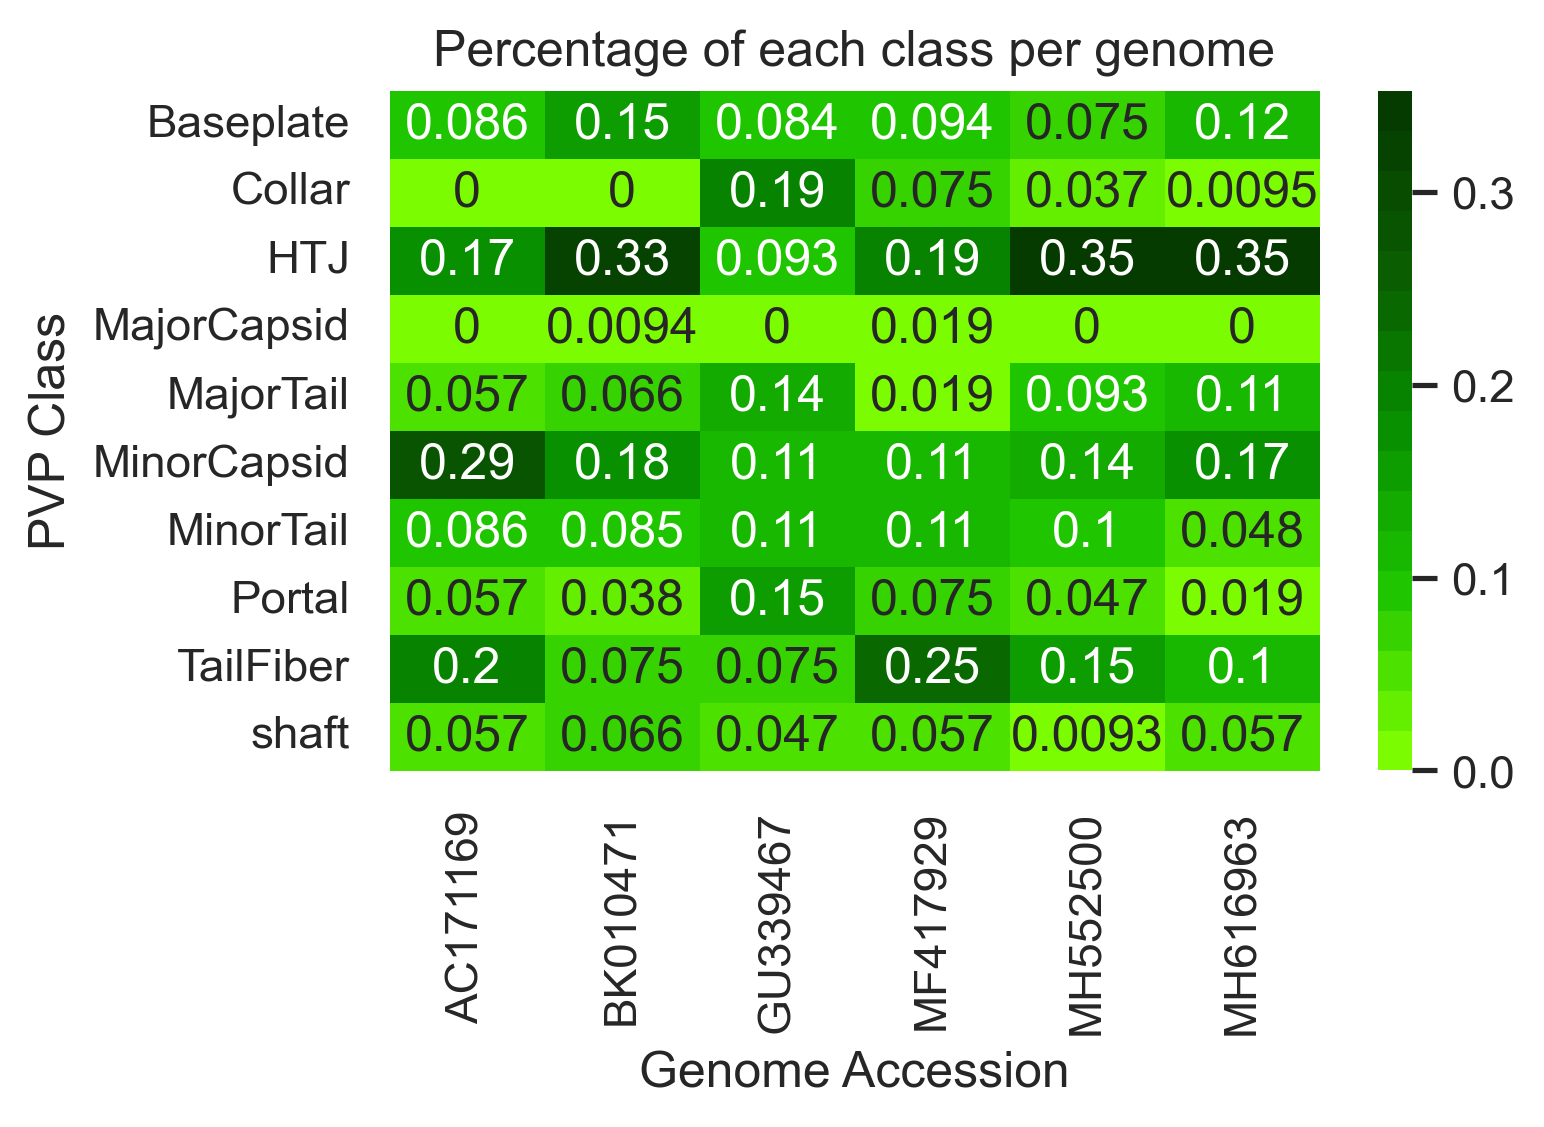

In [616]:
import seaborn as sns
import matplotlib.pyplot as plt

# normalize per row
classes_per_genome_normalized = classes_per_genome.div(classes_per_genome.sum(axis=1), axis=0)

# tranpose
classes_per_genome_normalized = classes_per_genome_normalized.T

# plot
plt.figure(figsize=(5, 3))  # You can adjust the figure size as per your needs
sns.heatmap(classes_per_genome_normalized, annot=True, cmap=shades_of_green)  # 'annot=True' to display the values in the cells, 'cmap' for color map
plt.title("Percentage of each class per genome")
plt.xlabel("Genome Accession")
plt.ylabel("PVP Class")
plt.show()

In [488]:
# matches with blast
def count_matches(group):
    series1 = group['PhageScanner (RNN)']
    series2 = group['BLAST']
    return series1.eq(series2).sum() / len(series1)

genome_df.groupby('accession').apply(count_matches)

accession
AC171169    0.057143
BK010471    0.066038
GU339467    0.084112
MF417929    0.056604
MH552500    0.102804
MH616963    0.114286
dtype: float64

In [585]:
protein_positions = {}

predictor = 'BLAST'#'PhageScanner (RNN)'

accession_set = genome_df['accession'].unique()
for accession in accession_set:
    # get accession group
    accession_group = genome_df[genome_df['accession'] == accession]
    genome_length = accession_group['length'].max()
    
    # grab classes unique to accession
    protein_classes = accession_group[predictor].unique()
    for prot_class in protein_classes:
        
        protein_group_df = accession_group[accession_group[predictor] == prot_class]
        
        # get start and end positions, then convert to scale 0-1
        start_positions = (protein_group_df['start_pos'].to_numpy() / genome_length)
        stop_positions = (protein_group_df['stop_pos'].to_numpy() / genome_length)
        
        # add start and end positions to dictionary
        for index in range(len(start_positions)):
            if prot_class in protein_positions:
                protein_positions[prot_class].append(start_positions[index]) #, stop_positions[index]))
            else:
                protein_positions[prot_class] = [start_positions[index]] #, stop_positions[index])]
        break


/Users/dreyceyalbin/miniconda3/envs/phagescanner/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/dreyceyalbin/miniconda3/envs/phagescanner/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/dreyceyalbin/miniconda3/envs/phagescanner/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/dreyceyalbin/miniconda3/envs/phagescanner/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shad

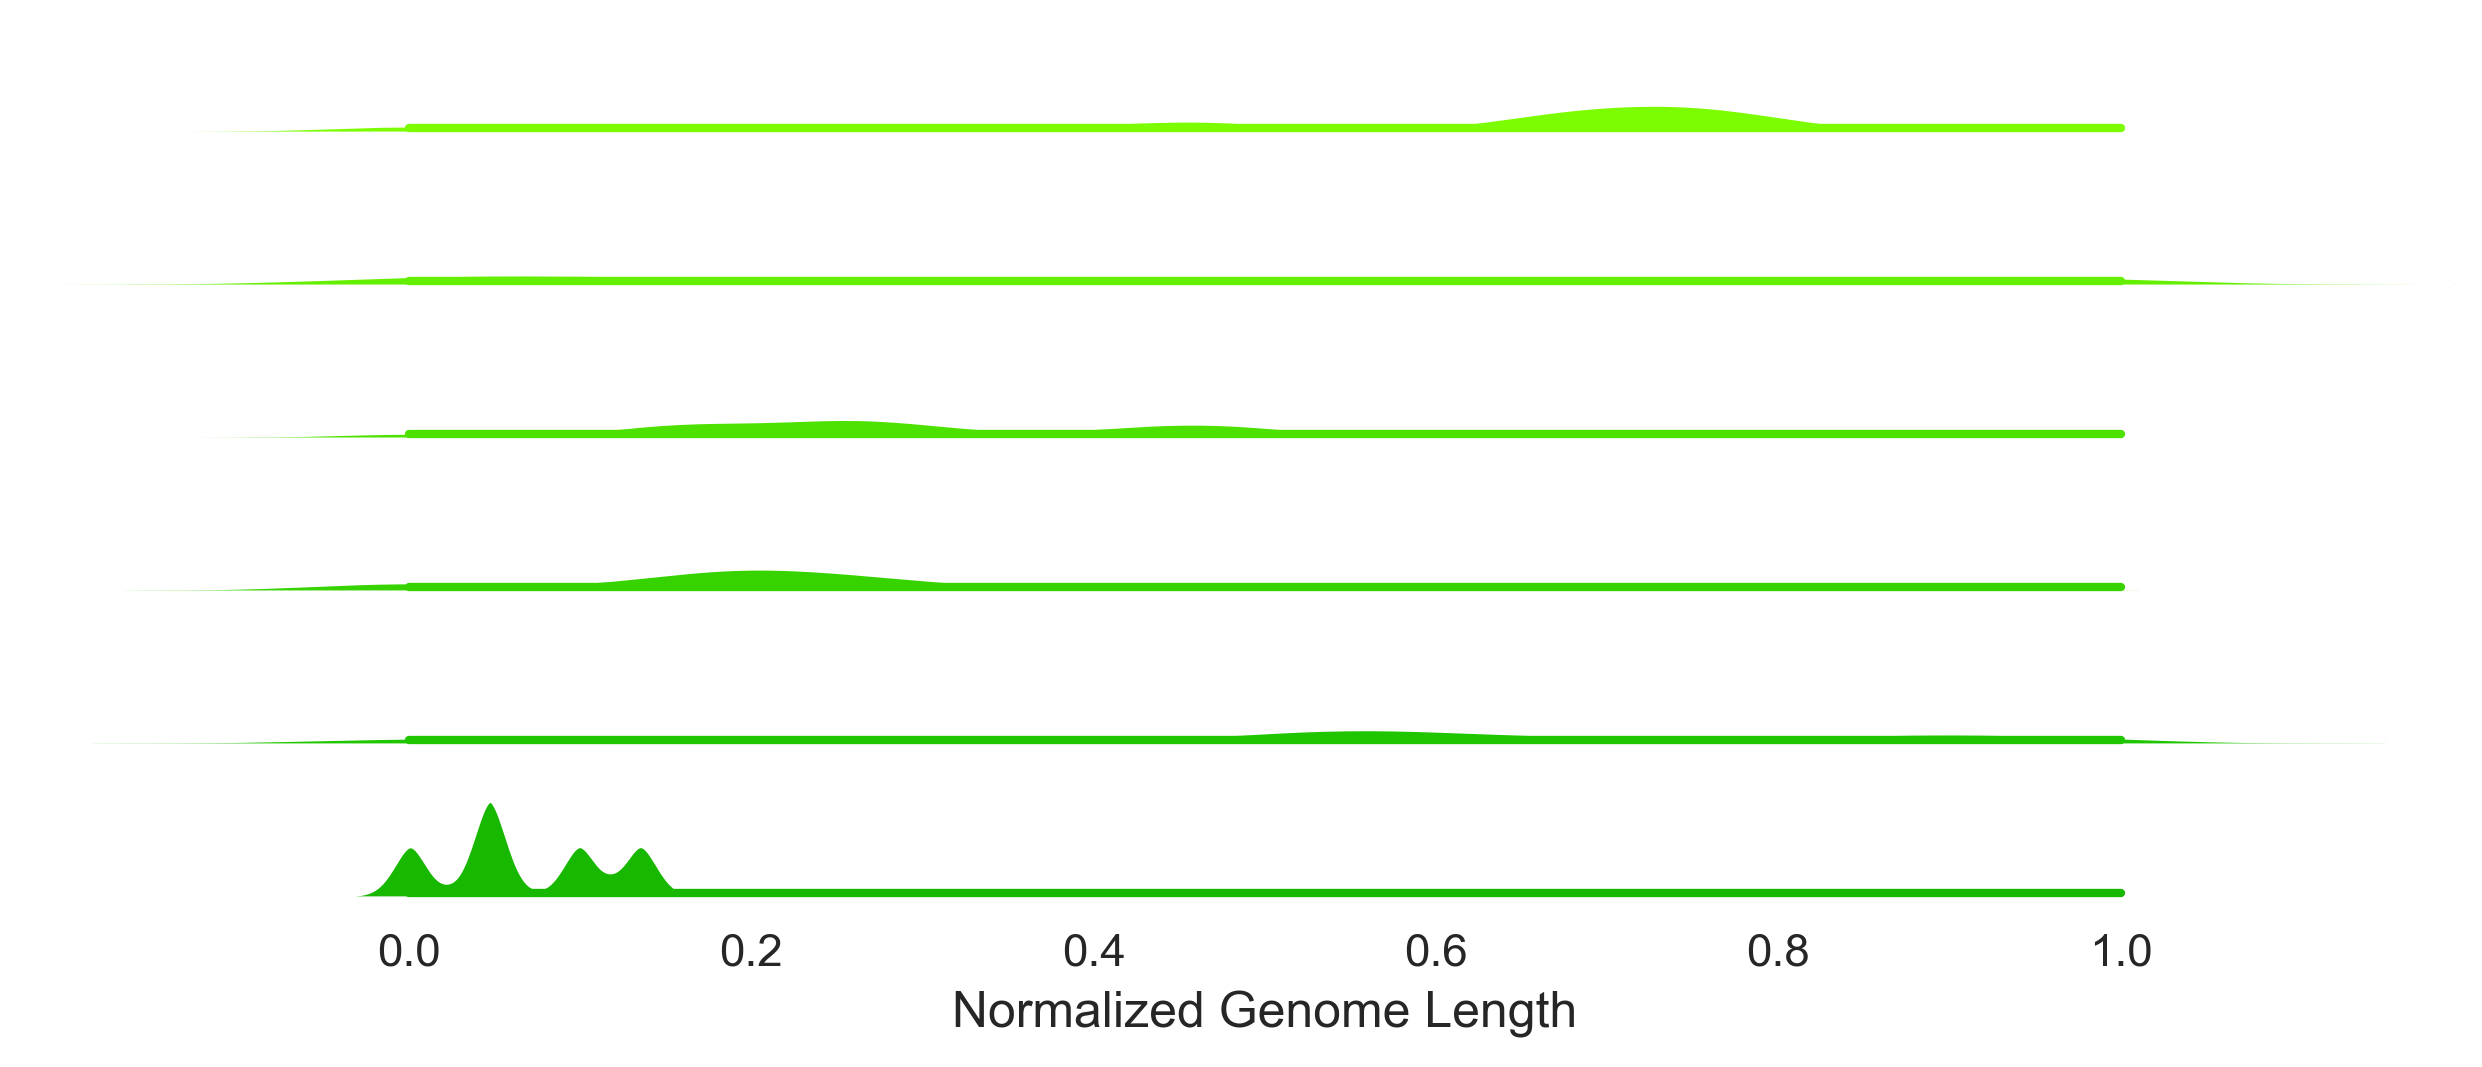

In [622]:
# Convert the dictionary into a DataFrame for easier plotting
data = []
for protein, positions in protein_positions.items():
    for position in positions:
        data.append({'PVP Class': protein, 'Start Position': position})
df = pd.DataFrame(data)

# Create a FacetGrid, which sets up a subplot for each unique value in the "Protein" column
g = sns.FacetGrid(df, row="PVP Class", hue="PVP Class", aspect=15, height=0.65, palette=shades_of_green, legend_out=True)

# For each subplot, plot a kdeplot of the "Start Position" column
g.map(sns.kdeplot, "Start Position", clip_on=False, shade=True, alpha=1, lw=1.5, bw_method=0.2)
g.map(sns.kdeplot, "Start Position", clip_on=False, color="w", lw=2, bw_method=0.2)

# Remove the y-axis labels and ticks
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.set(xlim=(0, 1), yticks=[])
g.set_xlabels('Normalized Genome Length')
g.set_ylabels('')
g.set_titles(row_template="")

# Set the title for each subplot
for ax in g.axes.flat:
    ax.text(0.0, 0.2, ax.get_title(), fontweight="bold", 
            ha="left", transform=ax.transAxes)

# Remove the subplot titles and the global title
g.set_titles("")
g.fig.suptitle("")

# Add white gridlines for the x-axis
g.map(plt.axhline, y=0, lw=2, clip_on=False)

plt.show()
